# Incidence of MACE

In [1]:
library(readr)
library(dplyr, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(purrr)
library(ggplot2)
library(Matrix,  warn.conflicts = FALSE)
library(lme4, warn.conflicts = FALSE)
library(lmerTest, warn.conflicts = FALSE)

In [2]:
options(repr.plot.res = 300)

## Importing results

In [3]:
result_tab <- tibble(
    cohort = c("ukb", "maastricht", "rotterdam", "ghs")
)
result_tab

cohort
<chr>
ukb
maastricht
rotterdam
ghs


In [4]:
result_tab <- result_tab %>%
    mutate(
        data = map(
            cohort,
            ~tryCatch(rio::import(paste0("../data/", .x, "/result_file2.RData")),
                      error = \(e) NULL)
        )
    )
print(result_tab)

# A tibble: 4 x 2
  cohort     data             
  <chr>      <list>           
1 ukb        <named list [15]>
2 maastricht <named list [5]> 
3 rotterdam  <named list [15]>
4 ghs        <named list [15]>


In [5]:
result_long <- result_tab %>%
    expand_grid(
        element_name = c(
            "SurvSum",
            "RatesByClus",
            "RatesByClusMeds",
            "SurvCoefs",
            "Comparison",
            "AdeqIndByClus",
            "AdeqIndByPre",
            "DCARes",
            "DCAClusREs",
            "InteractMods"
        )
    ) %>%
    transmute(
        cohort, element_name,
        element_value = map2(
            data, element_name,
            ~.x[[.y]]
        )
    ) %>%
    filter(!map_lgl(element_value, is.null))
print(result_long)

# A tibble: 30 x 3
   cohort element_name    element_value        
   <chr>  <chr>           <list>               
 1 ukb    SurvSum         <tibble [8 x 11]>    
 2 ukb    RatesByClus     <tibble [44 x 6]>    
 3 ukb    RatesByClusMeds <tibble [176 x 7]>   
 4 ukb    SurvCoefs       <tibble [16 x 8]>    
 5 ukb    Comparison      <tibble [8 x 19]>    
 6 ukb    AdeqIndByClus   <tibble [44 x 5]>    
 7 ukb    AdeqIndByPre    <tibble [208 x 5]>   
 8 ukb    DCARes          <tibble [832 x 11]>  
 9 ukb    DCAClusREs      <tibble [4,576 x 12]>
10 ukb    InteractMods    <tibble [48 x 9]>    
# i 20 more rows


In [6]:
result_long <- result_long %>%
    group_by(element_name) %>%
    summarise(
        element_value = list(
            bind_rows(
                map2(
                    element_value, cohort, 
                    ~mutate(.x, cohort = .y, .before = 1)
                )
            )
        )
    )
print(result_long)

# A tibble: 10 x 2
   element_name    element_value         
   <chr>           <list>                
 1 AdeqIndByClus   <tibble [110 x 6]>    
 2 AdeqIndByPre    <tibble [520 x 6]>    
 3 Comparison      <tibble [20 x 20]>    
 4 DCAClusREs      <tibble [11,440 x 13]>
 5 DCARes          <tibble [2,080 x 12]> 
 6 InteractMods    <tibble [112 x 10]>   
 7 RatesByClus     <tibble [110 x 7]>    
 8 RatesByClusMeds <tibble [418 x 8]>    
 9 SurvCoefs       <tibble [40 x 9]>     
10 SurvSum         <tibble [20 x 12]>    


---

## Summary of survival data

In [7]:
survsumd <- result_long %>%
    filter(element_name == "SurvSum") %>%
    select(-element_name) %>%
    unnest(element_value)
survsumd

cohort,sex,outcome,fut,N,Ncases,TPT,timeq2.5,timeq25,timeq50,timeq75,timeq97.5
<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ukb,Female,MACE,5,73378,1349,363900.47,5.000000,5.000000,5.000000,5.000000,5.000000
ukb,Female,MACE,10,73378,2926,644647.97,6.366667,8.104038,8.947296,9.607118,10.000000
ukb,Male,MACE,5,60348,2506,295798.65,3.159480,5.000000,5.000000,5.000000,5.000000
ukb,Male,MACE,10,60348,4927,519200.69,3.159480,8.027379,8.895277,9.593429,10.000000
ukb,Female,DM,5,34581,665,171313.82,5.000000,5.000000,5.000000,5.000000,5.000000
ukb,Female,DM,10,34581,1159,303403.57,6.151951,8.202601,8.870637,9.604381,10.000000
ukb,Male,DM,5,29006,938,142786.52,3.909993,5.000000,5.000000,5.000000,5.000000
ukb,Male,DM,10,29006,1578,251704.78,3.909993,8.109514,8.851472,9.587953,10.000000
rotterdam,Female,MACE,5,5353,224,25751.02,1.887526,5.000000,5.000000,5.000000,5.000000


---

## Risk of MACE and T2D in discordant clusters relative to concordant cluster

In [8]:
ratesbyclusdf <- result_long %>%
    filter(element_name == "RatesByClus") %>%
    select(-element_name) %>%
    unnest(element_value)
head(ratesbyclusdf)

cohort,sex,outcome,Cluster,Ncases,TPT,fut
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
ukb,Female,MACE,probBC,956.80374,276917.20,5
ukb,Female,MACE,probDAL,92.19911,18711.26,5
ukb,Female,MACE,probDHG,50.83606,6323.39,5
ukb,Female,MACE,probDHT,130.33750,35971.92,5
ukb,Female,MACE,probDIS,72.22930,12668.50,5
ukb,Female,MACE,probDLT,46.59429,13308.20,5


In [9]:
rrbycohort <- ratesbyclusdf %>%
    nest(D = -c(cohort, sex, outcome, fut)) %>%
    mutate(
        mod = map(
            D,
            ~glm(round(Ncases) ~ Cluster + offset(log(TPT)), data = .x, family = poisson)
        ),
        mod = map(mod, broom::tidy),
        mod = map(mod, mutate, term = gsub("Cluster", "", term), statistic = NULL),
        mod = map2(D, mod, left_join, by = c("Cluster" = "term")),
        D = NULL
    ) %>%
    unnest(mod)
head(rrbycohort)

cohort,sex,outcome,fut,Cluster,Ncases,TPT,estimate,std.error,p.value
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ukb,Female,MACE,5,probBC,956.80374,276917.20,NA,NA,NA
ukb,Female,MACE,5,probDAL,92.19911,18711.26,0.35257831,0.10915352,1.237409e-03
ukb,Female,MACE,5,probDHG,50.83606,6323.39,0.84748539,0.14371060,3.697962e-09
ukb,Female,MACE,5,probDHT,130.33750,35971.92,0.04471112,0.09347319,6.324147e-01
ukb,Female,MACE,5,probDIS,72.22930,12668.50,0.49746256,0.12220396,4.686071e-05
ukb,Female,MACE,5,probDLT,46.59429,13308.20,0.02168256,0.14940375,8.846104e-01


In [10]:
poolrrFE <- ratesbyclusdf %>%
    nest(D = -c(sex, outcome, fut)) %>%
    mutate(
        D = map(
            D,
            ~{
                mod <- glm(
                    round(Ncases) ~ Cluster + offset(log(TPT)), 
                    data = .x, 
                    family = poisson
                ) %>%
                    broom::tidy() %>%
                    mutate(
                        term = gsub("Cluster", "", term), 
                        statistic = NULL
                    )
                dat <- .x %>%
                    group_by(Cluster) %>%
                    summarise(across(c(Ncases, TPT), sum))
                left_join(dat, mod, by = c("Cluster" = "term"))
            }
        )
    ) %>%
    unnest(D)
head(poolrrFE)

sex,outcome,fut,Cluster,Ncases,TPT,estimate,std.error,p.value
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,MACE,5,probBC,1206.87400,322627.013,NA,NA,NA
Female,MACE,5,probDAL,99.85495,19673.078,0.30652277,0.10406008,3.222949e-03
Female,MACE,5,probDHG,91.17891,9100.353,0.98314997,0.10870834,1.511464e-19
Female,MACE,5,probDHT,135.97836,37525.758,-0.03176902,0.09045132,7.254174e-01
Female,MACE,5,probDIS,87.01962,14516.164,0.47124900,0.11100788,2.184132e-05
Female,MACE,5,probDLT,63.09416,18456.226,-0.07591502,0.12827120,5.539630e-01


In [11]:
poolrrRE <- ratesbyclusdf %>%
    nest(D = -c(sex, outcome, fut)) %>%
    mutate(
        D = map(
            D,
            ~{
                mod <- glmer(
                    round(Ncases) ~ Cluster + offset(log(TPT)) + (1|cohort), 
                    data = .x, 
                    family = poisson
                ) %>%
                    broom.mixed::tidy() %>%
                    mutate(
                        term = gsub("Cluster", "", term), 
                        across(c(effect, group, statistic), \(x) NULL)
                    )
                dat <- .x %>%
                    group_by(Cluster) %>%
                    summarise(across(c(Ncases, TPT), sum))
                left_join(dat, mod, by = c("Cluster" = "term"))
            }
        )
    ) %>%
    unnest(D)
head(poolrrRE)

sex,outcome,fut,Cluster,Ncases,TPT,estimate,std.error,p.value
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,MACE,5,probBC,1206.87400,322627.013,NA,NA,NA
Female,MACE,5,probDAL,99.85495,19673.078,0.343242854,0.10430178,9.988064e-04
Female,MACE,5,probDHG,91.17891,9100.353,0.811336268,0.11053284,2.132303e-13
Female,MACE,5,probDHT,135.97836,37525.758,0.006680287,0.09078824,9.413438e-01
Female,MACE,5,probDIS,87.01962,14516.164,0.477538187,0.11096949,1.682509e-05
Female,MACE,5,probDLT,63.09416,18456.226,-0.066468468,0.12881843,6.058644e-01


In [12]:
allRRs <- bind_rows(
    PooledFE = poolrrFE,
    PooledRE = poolrrRE,
    .id = "cohort"
) %>%
    bind_rows(rrbycohort) %>%
    mutate(
        cohort = factor(
            case_match(
                cohort,
                "ukb" ~ "UKB",
                "maastricht" ~ "MAS",
                "rotterdam" ~ "RTD",
                "ghs" ~ "GHS",
                .default = cohort
            ),
            levels = c("UKB", "MAS", "RTD", "GHS", "PooledFE", "PooledRE")
        ),      
        RR = exp(estimate),
        LOWERCI = exp(estimate - qnorm(1 - .05/2)*std.error),
        UPPERCI = exp(estimate + qnorm(1 - .05/2)*std.error)
    ) %>%
    arrange(sex, outcome, Cluster, fut, cohort)
head(allRRs, 10)
nrow(allRRs)

cohort,sex,outcome,fut,Cluster,Ncases,TPT,estimate,std.error,p.value,RR,LOWERCI,UPPERCI
<fct>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UKB,Female,DM,5,probBC,407.88641,131002.908,NA,NA,NA,NA,NA,NA
RTD,Female,DM,5,probBC,154.03879,20605.177,NA,NA,NA,NA,NA,NA
GHS,Female,DM,5,probBC,95.74291,25273.319,NA,NA,NA,NA,NA,NA
PooledFE,Female,DM,5,probBC,657.66810,176881.404,NA,NA,NA,NA,NA,NA
PooledRE,Female,DM,5,probBC,657.66810,176881.404,NA,NA,NA,NA,NA,NA
UKB,Female,DM,10,probBC,753.10891,231997.789,NA,NA,NA,NA,NA,NA
RTD,Female,DM,10,probBC,273.92908,34399.402,NA,NA,NA,NA,NA,NA
PooledFE,Female,DM,10,probBC,1027.03799,266397.191,NA,NA,NA,NA,NA,NA
PooledRE,Female,DM,10,probBC,1027.03799,266397.191,NA,NA,NA,NA,NA,NA


[1] 198

In [13]:
write_tsv(allRRs, "../data/allRRs.tsv")

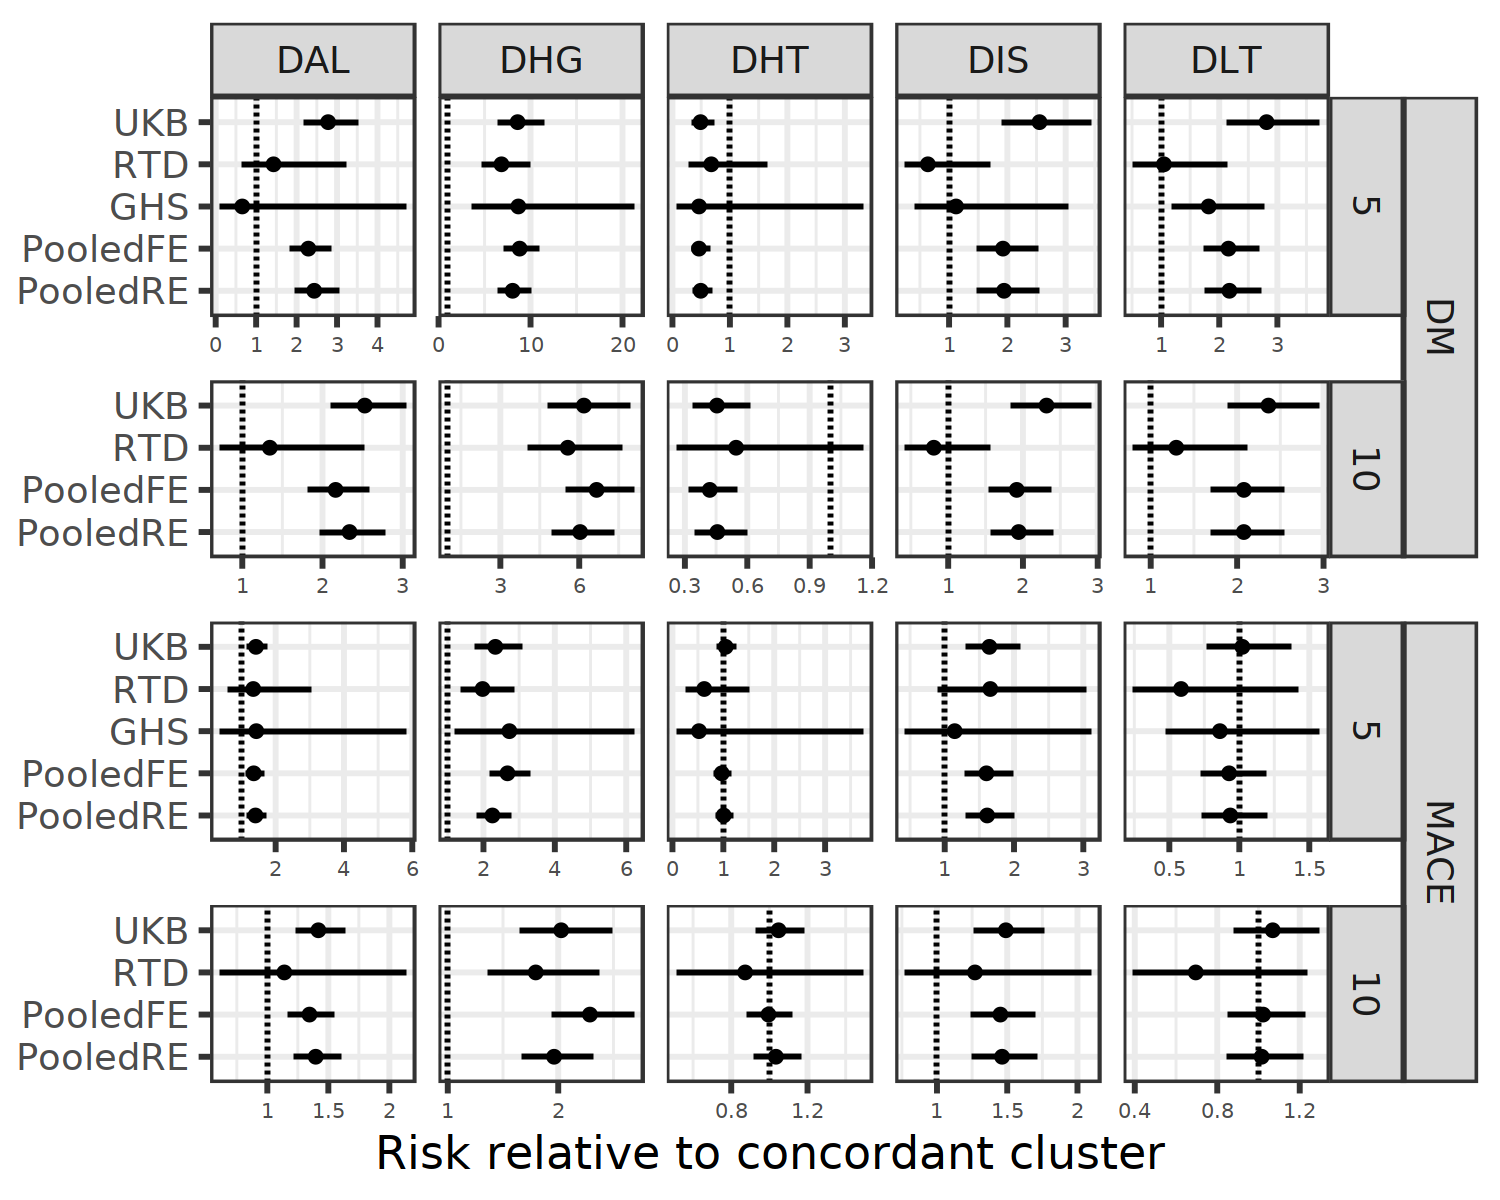

In [14]:
options(repr.plot.width = 5, repr.plot.height = 4)
allRRs %>%
    drop_na %>%
    filter(sex == "Female") %>%
    mutate(Cluster = gsub("prob", "", Cluster)) %>%
    ggplot(aes(RR, reorder(cohort, desc(cohort)))) +
    geom_vline(xintercept = 1, lty = "dashed") +
    geom_linerange(aes(xmin = LOWERCI, xmax = UPPERCI)) +
    geom_point(aes(shape = cohort == "Pooled"), show.legend = FALSE) +
    scale_shape_manual(values = c(20, 23)) +
    ggh4x::facet_nested(
        outcome+fut~Cluster, scales = "free", independent = "x",
        space = "free_y"
    ) +
    scale_x_continuous(n.breaks = 4, labels = \(x)round(x, 1)) +
    labs(x = "Risk relative to concordant cluster", y = NULL) +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5)
    )

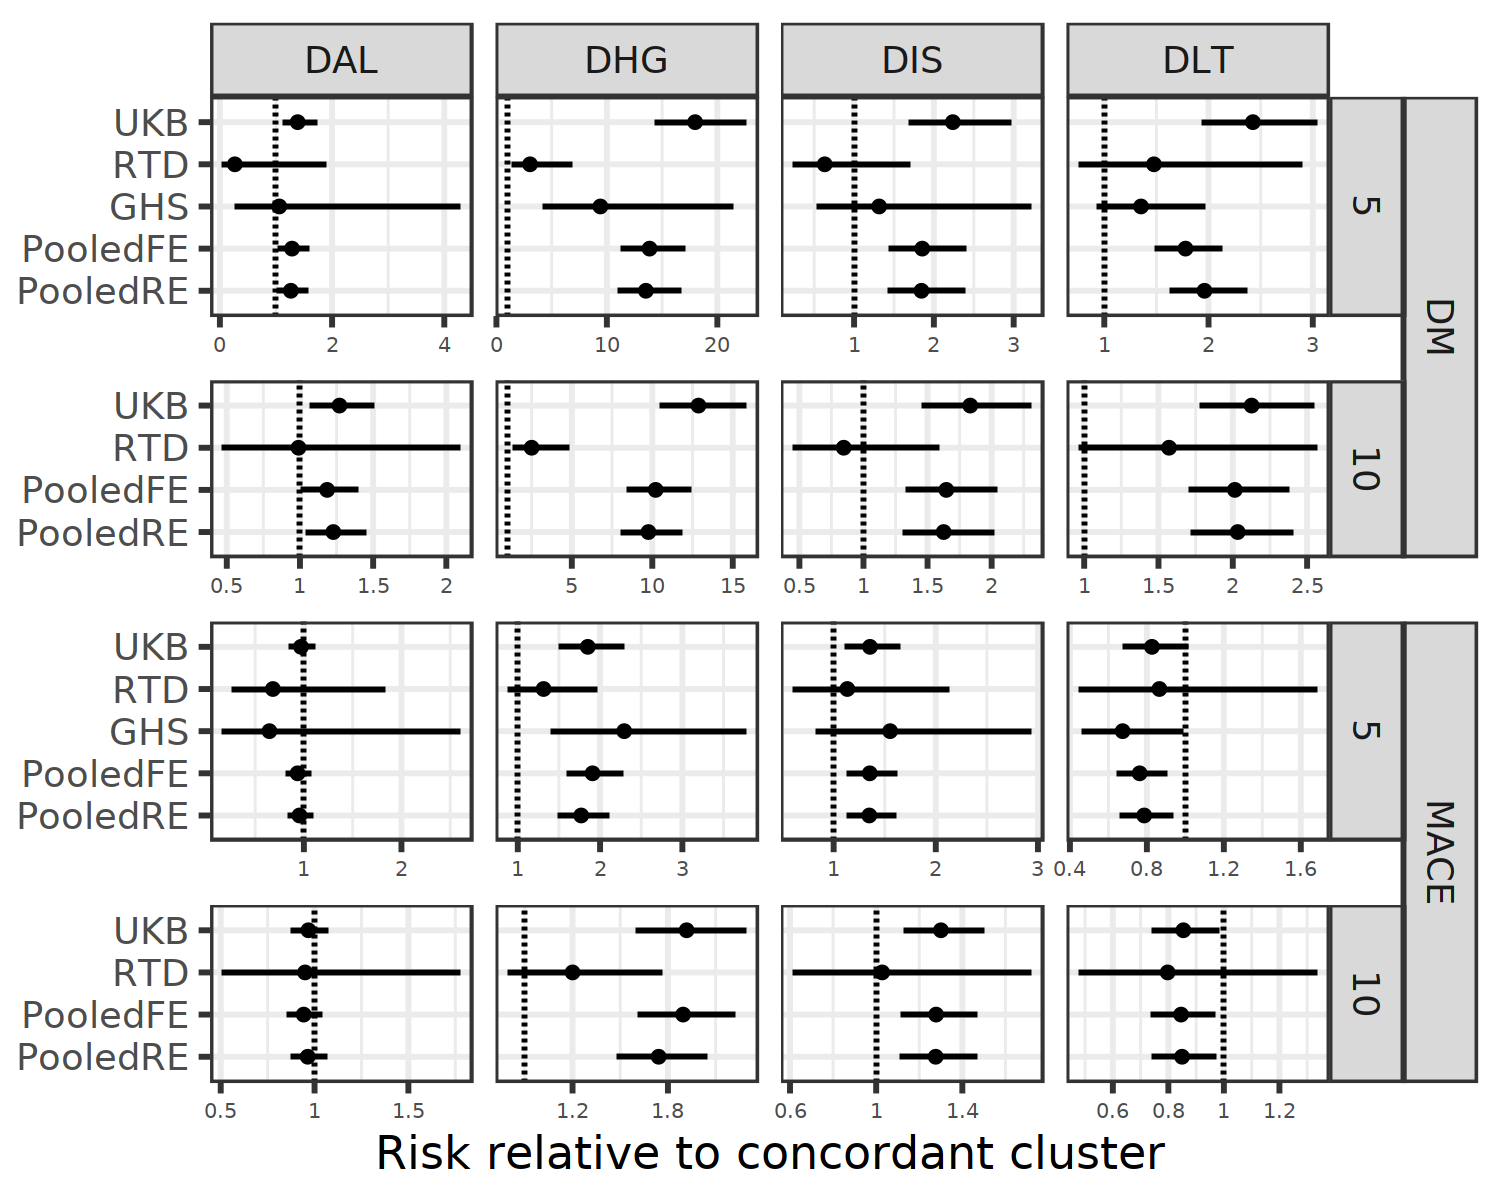

In [15]:
options(repr.plot.width = 5, repr.plot.height = 4)
allRRs %>%
    drop_na %>%
    filter(sex == "Male") %>%
    mutate(Cluster = gsub("prob", "", Cluster)) %>%
    ggplot(aes(RR, reorder(cohort, desc(cohort)))) +
    geom_vline(xintercept = 1, lty = "dashed") +
    geom_linerange(aes(xmin = LOWERCI, xmax = UPPERCI)) +
    geom_point(aes(shape = cohort == "Pooled"), show.legend = FALSE) +
    scale_shape_manual(values = c(20, 23)) +
    ggh4x::facet_nested(
        outcome+fut~Cluster, scales = "free", independent = "x",
        space = "free_y"
    ) +
    scale_x_continuous(n.breaks = 4, labels = \(x)round(x, 1)) +
    labs(x = "Risk relative to concordant cluster", y = NULL) +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5)
    )

---

## Significance of models with clusters

In [16]:
comparedat <- result_long %>% 
    filter(element_name == "Comparison") %>%
    select(-element_name) %>%
    unnest(element_value)
comparedat

cohort,sex,outcome,fut,LL0,LLBase,NVBase,LLBaseCl,NVBaseCl,LRTstat,LRTdf,LRTp,AdeqInd,CBase,CseBase,CBaseCl,CseBaseCl,Cdiff,Cdiffse,Cdiffp
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ukb,Female,MACE,5,-15100.8913,-14618.8477,30,-14607.4305,35,22.8343844,5,3.630825e-04,0.9768630,0.7328223,0.006465895,0.7344978,0.006473680,1.675418e-03,0.0009406441,7.488974e-02
ukb,Female,MACE,10,-32421.9721,-31439.4634,30,-31425.8677,35,27.1914864,5,5.234738e-05,0.9863511,0.7264155,0.004463970,0.7275248,0.004465290,1.109259e-03,0.0005270384,3.531727e-02
ukb,Male,MACE,5,-27533.0088,-26845.5137,30,-26805.9617,34,79.1040246,4,2.696446e-16,0.9455991,0.7036140,0.004698475,0.7088752,0.004684074,5.261199e-03,0.0012679722,3.334912e-05
ukb,Male,MACE,10,-53605.7315,-52507.1455,30,-52458.6313,34,97.0285554,4,4.219367e-20,0.9577070,0.6854264,0.003528423,0.6894910,0.003534826,4.064634e-03,0.0008366927,1.185908e-06
ukb,Female,DM,5,-6943.5290,-6165.9608,22,-6165.1279,27,1.6658616,5,8.931722e-01,0.9989299,0.8723565,0.006691853,0.8722215,0.006714578,-1.349738e-04,0.0002306181,5.583663e-01
ukb,Female,DM,10,-12041.2512,-10901.8125,22,-10896.1640,27,11.2968177,5,4.580241e-02,0.9950673,0.8543404,0.005291641,0.8548817,0.005284485,5.412843e-04,0.0003872531,1.621872e-01
ukb,Male,DM,5,-9622.8757,-8708.9414,22,-8708.3226,26,1.2376982,4,8.718537e-01,0.9993233,0.8412190,0.006265155,0.8413424,0.006251815,1.234357e-04,0.0001595101,4.390240e-01
ukb,Male,DM,10,-16105.2579,-14836.2379,22,-14831.4438,26,9.5882731,4,4.796469e-02,0.9962364,0.8210544,0.005080388,0.8222832,0.005046399,1.228734e-03,0.0003787754,1.178782e-03
rotterdam,Female,MACE,5,-1913.3393,-1805.0576,23,-1804.8888,28,0.3376279,5,9.968749e-01,0.9984434,0.7682713,0.014212733,0.7688271,0.014247435,5.557690e-04,0.0006589452,3.989924e-01


---

## Estimates from log-contrast models

In [17]:
survcoefd <- result_long %>% 
    filter(element_name == "SurvCoefs") %>%
    select(-element_name) %>%
    unnest(element_value)
print(survcoefd)

# A tibble: 40 x 9
   cohort sex    outcome   fut model estimates  varcovmat  Means  Afit        
   <chr>  <chr>  <chr>   <dbl> <chr> <list>     <list>     <list> <list>      
 1 ukb    Female MACE        5 base  <dbl [30]> <dbl[...]> <dbl>  <named list>
 2 ukb    Female MACE        5 clus  <dbl [35]> <dbl[...]> <dbl>  <named list>
 3 ukb    Female MACE       10 base  <dbl [30]> <dbl[...]> <dbl>  <named list>
 4 ukb    Female MACE       10 clus  <dbl [35]> <dbl[...]> <dbl>  <named list>
 5 ukb    Male   MACE        5 base  <dbl [30]> <dbl[...]> <dbl>  <named list>
 6 ukb    Male   MACE        5 clus  <dbl [34]> <dbl[...]> <dbl>  <named list>
 7 ukb    Male   MACE       10 base  <dbl [30]> <dbl[...]> <dbl>  <named list>
 8 ukb    Male   MACE       10 clus  <dbl [34]> <dbl[...]> <dbl>  <named list>
 9 ukb    Female DM          5 base  <dbl [22]> <dbl[...]> <dbl>  <named list>
10 ukb    Female DM          5 clus  <dbl [27]> <dbl[...]> <dbl>  <named list>
# i 30 more rows


Given that shifts also represent changes in biomarker values, we need to recreate all biomarker values that would cause the shift.

### Effect of 10% shift in cluster probability from concordant to discordant clusters

In [18]:
load("../data/validclusmod.RData")

In [19]:
print(validclusmod)

# A tibble: 2 x 3
  sex    residmod          clusmod         
  <chr>  <list>            <list>          
1 Female <tibble [10 x 6]> <tibble [6 x 4]>
2 Male   <tibble [10 x 6]> <tibble [5 x 4]>


In [20]:
egfrcalc <- function(scr, sex, age){
    scr <- scr / 88.42
    alpha <- ((sex == "Female") * -0.241) + ((sex == "Male") * -0.302)
    kappa <- ((sex == "Female") * 0.7) + ((sex == "Male") * 0.9)
    creat_kappa <- scr / kappa
    minkappa <- pmin(creat_kappa, 1) 
    maxkappa <- pmax(creat_kappa, 1)
    minkappa_alpha <- minkappa^alpha
    maxkappa_exp <- maxkappa^(-1.200)
    age_term <- 0.9938^age
    sex_term <- ((sex == "Female") * 1.012) + ((sex == "Male") * 1) 
    142 * minkappa_alpha * maxkappa_exp * age_term * sex_term
}

In [21]:
shift10pc <- validclusmod %>%
    transmute(
        sex,
        ResD = map(
            clusmod,
            function(CLUSMOD){
                CLUSMOD %>%
                    expand_grid(
                        Cluster = CLUSMOD$validclus_name
                    ) %>%
                    mutate(
                        toadd = case_when(
                            Cluster == "BC" ~ 0,
                            Cluster == validclus_name ~ .1,
                            validclus_name == "BC" ~ -.1,
                            TRUE ~ 0
                        ),
                        validclus_weights = validclus_weights + toadd
                    ) %>%
                    group_by(Cluster) %>%
                    summarise(
                        RGD = list(
                            MGMM::rGMM(
                                n = 5e5, 
                                d = length(validclus_centers[[1]]),
                                k = n(),
                                pi = validclus_weights,
                                means = validclus_centers, 
                                covs = validclus_covmats
                            ) %>%
                                colMeans %>%
                                round(2) %>%
                                setNames(
                                    names(validclus_centers[[1]])
                                )
                        )
                    )
            }
        ),
        NewD = pmap(
            list(ResD, residmod, clusmod),
            function(D, RESIDMOD, CLUSMOD){
                D %>%
                    mutate(
                        predprobs = map(
                            RGD, 
                            ~{
                                pdfs <- mapply(
                                    function(mu, covmat){ 
                                        mvtnorm::dmvnorm(
                                            .x, mu, covmat
                                        ) 
                                    },
                                    CLUSMOD$validclus_centers, 
                                    CLUSMOD$validclus_covmats
                                )
                                L <- pdfs %*% diag(CLUSMOD$validclus_weights)
                                colnames(L) <- CLUSMOD$validclus_name
                                L / rowSums(L)
                            }
                        ),
                        alrprobs = map(
                            predprobs,
                            ~{
                                cclus <- colnames(.x) == "BC"
                                alrp <- .x[,!cclus]/.x[,cclus]
                                names(alrp) <- paste0("alrprob", names(alrp))
                                t(alrp)
                            }
                        ),
                        actualbmvals = map(
                            RGD,
                            ~tibble(
                                Biomarker = names(.x), sdresidval = .x
                            ) %>%
                                inner_join(RESIDMOD, by = "Biomarker") %>%
                                mutate(
                                    sdresid = sdresidval * SDRes,
                                    bmi = 30 * bmi,
                                    age = 60 * age,
                                    bmvalue = rowSums(pick(Intercept, bmi, age, sdresid))
                                ) %>%
                                {setNames(.$bmvalue, .$Biomarker)} %>%
                                c(bmi = 30, age = 60) %>% t
                        ),
                        joindat = map2(actualbmvals, alrprobs, cbind)
                    ) %>%
                    transmute(Cluster, joindat = map(joindat, data.frame)) %>%
                    unnest(joindat)
            }
        ),
        NewD = map2(
            NewD, sex,
            ~mutate(
                .x, 
                lnegfr = log(egfrcalc(scr, .y, 60)),
                lnegfrsq = lnegfr^2,
                age_lnegfr = 60*lnegfr,
                tchol = hdl + ldl + (tg/2.2),
                age_tchol = 60*tchol,
                age_sbp = 60*sbp,
                age_hdl = 60*hdl,
                age_fg = 60*fg
            )
        ),
        ResD
    )
print(shift10pc)

# A tibble: 2 x 3
  sex    ResD             NewD             
  <chr>  <list>           <list>           
1 Female <tibble [6 x 2]> <tibble [6 x 26]>
2 Male   <tibble [5 x 2]> <tibble [5 x 25]>


In [22]:
shift10pc$NewD %>%
    map(select, -starts_with("alrprob"), -bmi, -age)

Cluster,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg,lnegfr,lnegfrsq,age_lnegfr,tchol,age_tchol,age_sbp,age_hdl,age_fg
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BC,0.8393345,144.0713,84.46542,23.10239,64.97163,3.671760,1.524973,1.806155,3.744850,5.100617,4.536365,20.57861,272.1819,6.090802,365.4481,8644.280,91.49836,306.0370
DAL,0.8435855,144.0713,84.56026,23.38278,64.75872,3.642702,1.493450,2.052018,3.805027,5.088933,4.540304,20.61436,272.4182,6.231212,373.8727,8644.280,89.60703,305.3360
DHG,0.8411564,143.7161,84.18089,23.19585,64.75872,3.613644,1.514465,1.813606,3.684673,5.375186,4.540304,20.61436,272.4182,6.023505,361.4103,8622.967,90.86792,322.5111
DHT,0.8369055,147.0906,85.98287,22.82200,64.86517,3.613644,1.531978,1.776354,3.727657,5.100617,4.538333,20.59646,272.3000,6.067068,364.0241,8825.434,91.91866,306.0370
DIS,0.8393345,143.8937,84.46542,22.91546,64.86517,4.863137,1.521470,1.798705,3.727657,5.088933,4.538333,20.59646,272.3000,6.066720,364.0032,8633.623,91.28821,305.3360
DLT,0.8411564,144.0713,84.56026,26.74743,64.75872,3.671760,1.521470,1.806155,3.744850,5.094775,4.540304,20.61436,272.4182,6.087300,365.2380,8644.280,91.28821,305.6865
Cluster,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg,lnegfr,lnegfrsq,age_lnegfr,tchol,age_tchol,age_sbp,age_hdl,age_fg
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BC,0.9611545,144.5955,85.97776,30.17961,82.39189,2.942365,1.228894,2.178218,3.464768,5.163501,4.540970,20.62041,272.4582,5.683761,341.0256,8675.727,73.73364,309.8100


In [23]:
shift10est <- survcoefd %>%
    filter(model == "clus") %>%
    inner_join(shift10pc, by = "sex") %>%
    transmute(
        cohort,
        sex,
        outcome,
        fut,
        estdat = pmap(
            list(NewD, estimates, varcovmat),
            function(D, BETAS, COVM){
                Dmat <- as.matrix(select(D, -Cluster))
                rownames(Dmat) <- D$Cluster
                cclus <- rownames(Dmat) == "BC"
                diffmat <- t(t(Dmat[!cclus,]) - Dmat[cclus,])
                nm <- intersect(colnames(diffmat), names(BETAS))
                covm <- COVM[nm,nm]
                data.frame(
                    Cluster = gsub("alrprob", "", rownames(diffmat)),
                    estimate = drop(diffmat[,nm] %*% BETAS[nm]),
                    se = apply(
                        diffmat[,nm], 1,
                        \(clus){ 
                            sqrt(drop(clus %*% covm %*% clus))
                        }
                    )
                )
            }
        )
    ) %>%
    unnest(estdat)
head(shift10est)

cohort,sex,outcome,fut,Cluster,estimate,se
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
ukb,Female,MACE,5,DAL,0.050596563,0.010488461
ukb,Female,MACE,5,DHG,-0.041528089,0.021518278
ukb,Female,MACE,5,DHT,0.009712011,0.007050954
ukb,Female,MACE,5,DIS,0.108895912,0.025730384
ukb,Female,MACE,5,DLT,-0.048920446,0.019991342
ukb,Female,MACE,10,DAL,0.043442964,0.007284402


In [24]:
poolshift10est <- shift10est %>%
    nest(D = -c(sex, outcome, Cluster, fut)) %>%
    mutate(
        D = map(D, ~meta::metagen(TE = .x$estimate, seTE = .x$se)),
        D = map(
            D, 
            ~tibble(
                cohort = c("Pooled_FE", "Pooled_RE"),
                estimate = c(.x$TE.fixed, .x$TE.random), 
                se = c(.x$seTE.fixed, .x$seTE.random)
            )
        )
    ) %>%
    unnest(D)
head(poolshift10est)

sex,outcome,fut,Cluster,cohort,estimate,se
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Female,MACE,5,DAL,Pooled_FE,0.049749004,0.009503442
Female,MACE,5,DAL,Pooled_RE,0.049748744,0.009505558
Female,MACE,5,DHG,Pooled_FE,-0.034454440,0.017889042
Female,MACE,5,DHG,Pooled_RE,-0.034454440,0.017889042
Female,MACE,5,DHT,Pooled_FE,0.008134098,0.006466517
Female,MACE,5,DHT,Pooled_RE,-0.002509294,0.022719192


In [36]:
allshift10est <- poolshift10est %>%
    bind_rows(shift10est) %>%
    mutate(
        cohort = factor(
            case_match(
                cohort,
                "ukb" ~ "UKB",
                "maastricht" ~ "MAS",
                "rotterdam" ~ "RTD",
                "ghs" ~ "GHS",
                .default = cohort
            ),
            levels = c("UKB", "MAS", "RTD", "GHS", "Pooled_FE", "Pooled_RE")
        ),
        pval = 2*pnorm(-abs(estimate/se)),
        hr = exp(estimate),
        lwr = exp(estimate - qnorm(.975)*se),
        upr = exp(estimate + qnorm(.975)*se)
    ) %>%
    transmute(
        sex, outcome, Cluster, fut, cohort,
        across(everything())
    ) %>%
    arrange(sex, outcome, Cluster, fut, cohort)
head(allshift10est)

sex,outcome,Cluster,fut,cohort,estimate,se,pval,hr,lwr,upr
<chr>,<chr>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,DM,DAL,5,UKB,0.10782411,0.02361850,4.989250e-06,1.1138518,1.0634653,1.166626
Female,DM,DAL,5,RTD,0.03139324,0.04405581,4.761064e-01,1.0318912,0.9465282,1.124953
Female,DM,DAL,5,GHS,-0.08742981,0.06931763,2.072035e-01,0.9162832,0.7998830,1.049622
Female,DM,DAL,5,Pooled_FE,0.07602154,0.01993635,1.371716e-04,1.0789858,1.0376380,1.121981
Female,DM,DAL,5,Pooled_RE,0.03241710,0.05334091,5.433637e-01,1.0329483,0.9304107,1.146786
Female,DM,DAL,10,UKB,0.10002622,0.01910854,1.653123e-07,1.1051999,1.0645734,1.147377


In [37]:
write_tsv(allshift10est, "../data/allshift10est.tsv")

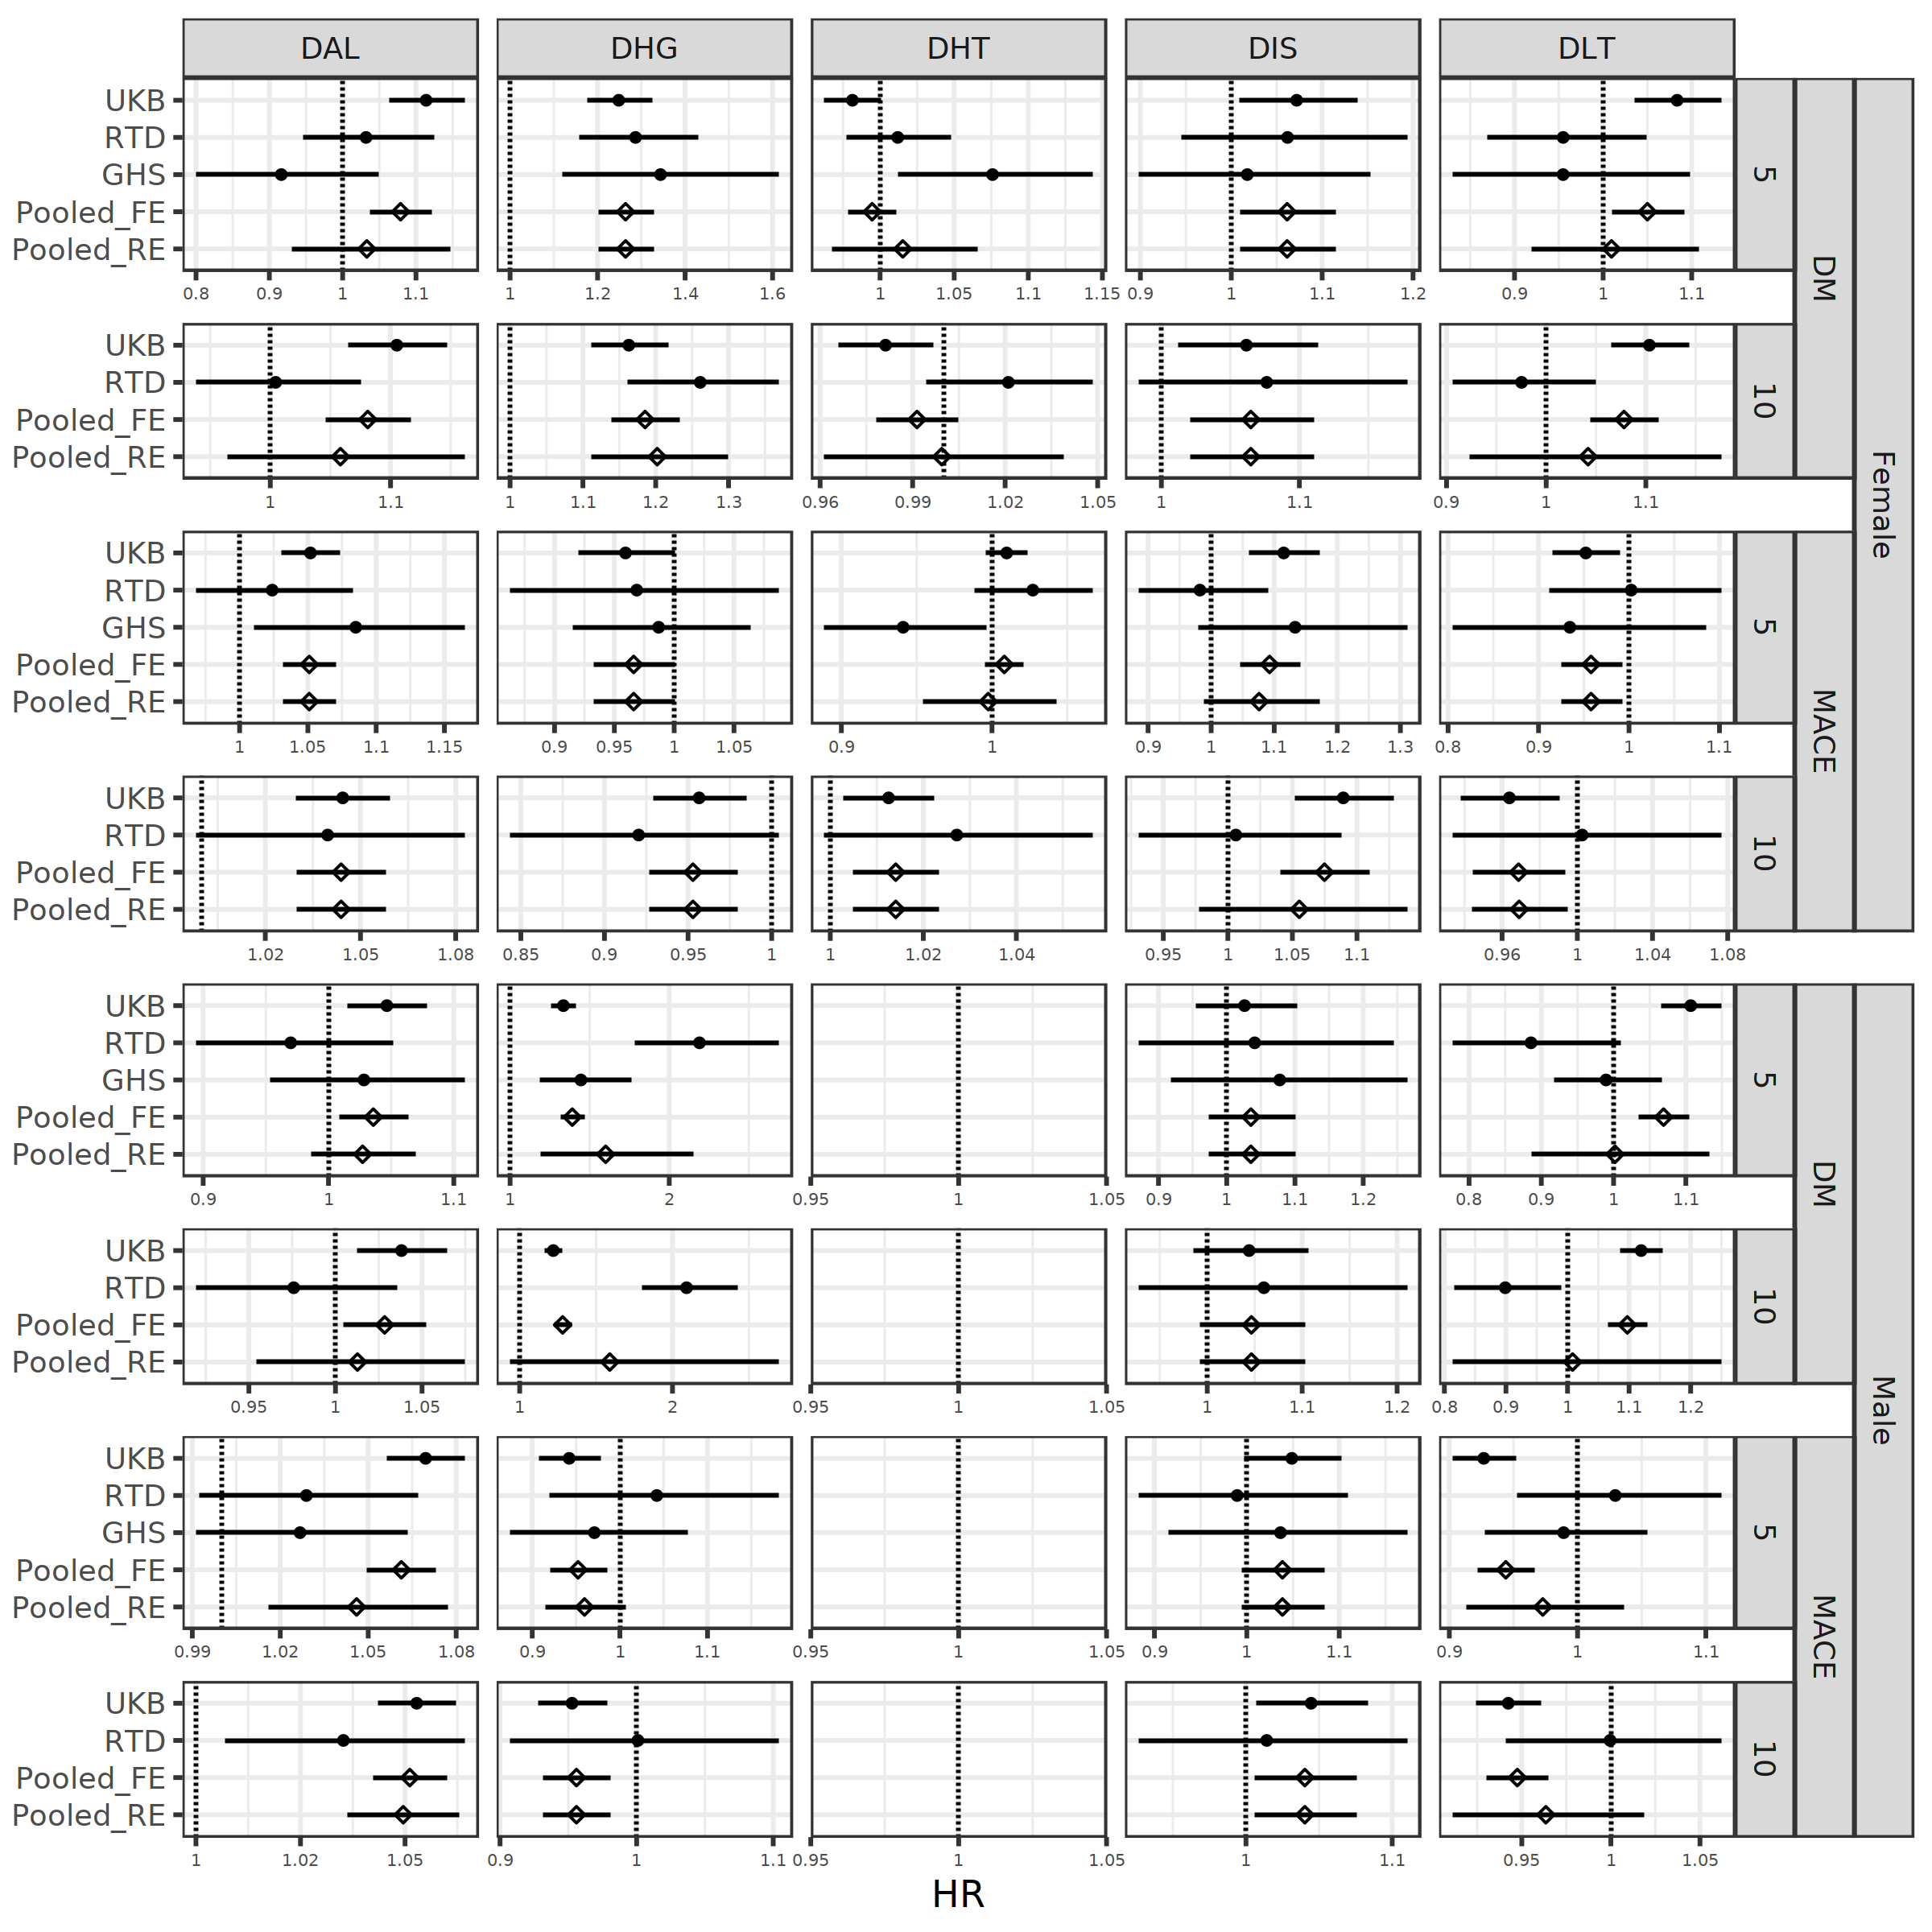

In [61]:
options(repr.plot.width = 8, repr.plot.height = 8)
allshift10est %>%
    drop_na %>%
    mutate(Cluster = gsub("prob", "", Cluster)) %>%
    ggplot(aes(hr, reorder(cohort, desc(cohort)))) +
    geom_vline(xintercept = 1, lty = "dashed") +
    geom_linerange(aes(xmin = lwr, xmax = upr)) +
    geom_point(aes(shape = grepl("Pooled", cohort)), show.legend = FALSE) +
    scale_shape_manual(values = c(20, 23)) +
    ggh4x::facet_nested(
        sex+outcome+fut~Cluster, scales = "free", independent = "x",
        space = "free_y"
    ) +
    scale_x_continuous(n.breaks = 4, labels = \(x)round(x, 2)) +
    labs(x = "HR", y = NULL) +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5)
    )

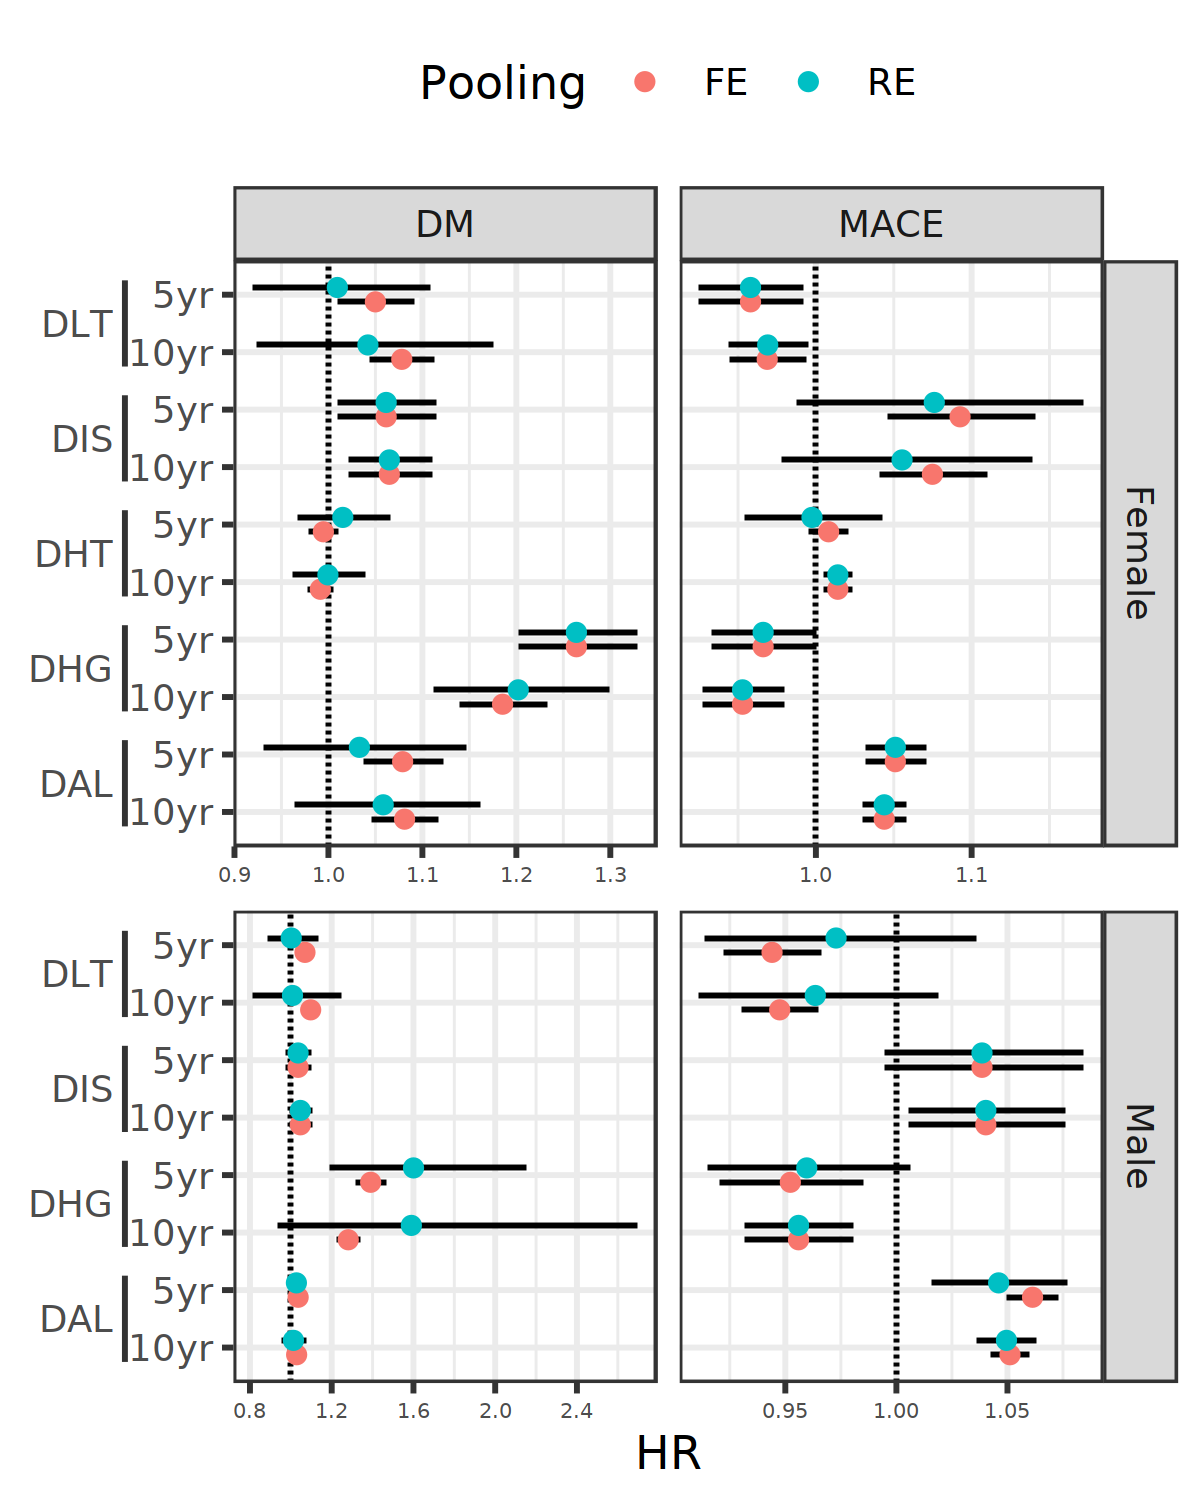

In [88]:
options(repr.plot.width = 4, repr.plot.height = 5)
poolshift10est %>%
    mutate(
        hr = exp(estimate),
        lwr = exp(estimate - qnorm(.975)*se),
        upr = exp(estimate + qnorm(.975)*se),
        fut = factor(
            paste0(fut, "yr"), 
            levels = c("10yr", "5yr")
        ),
        cohort = gsub("Pooled_", "", cohort),
        Cluster = gsub("prob", "", Cluster)
    ) %>%
    ggplot(aes(hr, interaction(fut, Cluster))) +
    geom_vline(xintercept = 1, lty = "dashed") +
    geom_linerange(
        aes(xmin = lwr, xmax = upr, group = cohort),
        position = position_dodge(width = .5)
    ) +
    geom_point(
        aes(group = cohort, color = cohort),
        position = position_dodge(width = .5)
    ) +
    scale_y_discrete(guide = ggh4x::guide_axis_nested()) +
    ggh4x::facet_nested(
        sex ~ outcome, scales = "free",
        independent = "x",
        space = "free_y"
    ) +
    labs(x = "HR", y = NULL, color = "Pooling") +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5),
        legend.position = "top"
    )

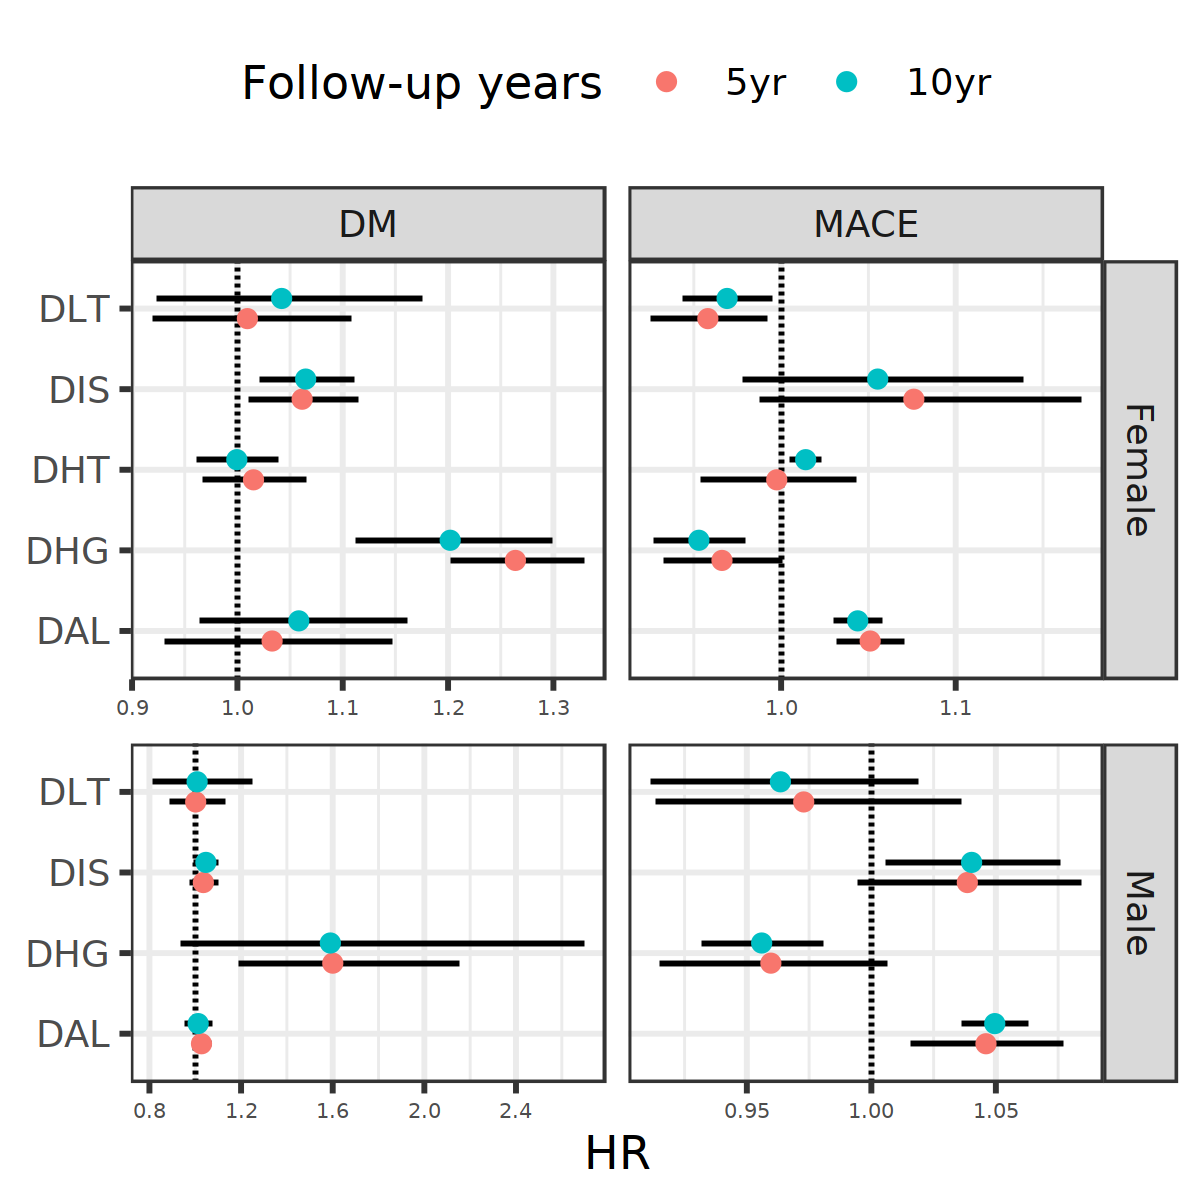

In [92]:
options(repr.plot.width = 4, repr.plot.height = 4)
poolshift10est %>%
    filter(cohort == "Pooled_RE") %>%
    mutate(
        hr = exp(estimate),
        lwr = exp(estimate - qnorm(.975)*se),
        upr = exp(estimate + qnorm(.975)*se),
        fut = factor(
            paste0(fut, "yr"), 
            levels = c("5yr", "10yr")
        ),
        Cluster = gsub("prob", "", Cluster)
    ) %>%
    ggplot(aes(hr, Cluster)) +
    geom_vline(xintercept = 1, lty = "dashed") +
    geom_linerange(
        aes(xmin = lwr, xmax = upr, group = fut),
        position = position_dodge(width = .5)
    ) +
    geom_point(
        aes(group = fut, color = fut),
        position = position_dodge(width = .5)
    ) +
    ggh4x::facet_nested(
        sex ~ outcome, scales = "free",
        independent = "x",
        space = "free_y"
    ) +
    labs(x = "HR", y = NULL, color = "Follow-up years") +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5),
        legend.position = "top"
    )

## Shift of 50% from concordant to discordant

In [93]:
shift50pc <- validclusmod %>%
    transmute(
        sex,
        ResD = map(
            clusmod,
            function(CLUSMOD){
                CLUSMOD %>%
                    expand_grid(
                        Cluster = CLUSMOD$validclus_name
                    ) %>%
                    mutate(
                        toadd = case_when(
                            Cluster == "BC" ~ 0,
                            Cluster == validclus_name ~ .5,
                            validclus_name == "BC" ~ -.5,
                            TRUE ~ 0
                        ),
                        validclus_weights = validclus_weights + toadd
                    ) %>%
                    group_by(Cluster) %>%
                    summarise(
                        RGD = list(
                            MGMM::rGMM(
                                n = 5e5, 
                                d = length(validclus_centers[[1]]),
                                k = n(),
                                pi = validclus_weights,
                                means = validclus_centers, 
                                covs = validclus_covmats
                            ) %>%
                                colMeans %>%
                                round(2) %>%
                                setNames(
                                    names(validclus_centers[[1]])
                                )
                        )
                    )
            }
        ),
        NewD = pmap(
            list(ResD, residmod, clusmod),
            function(D, RESIDMOD, CLUSMOD){
                D %>%
                    mutate(
                        predprobs = map(
                            RGD, 
                            ~{
                                pdfs <- mapply(
                                    function(mu, covmat){ 
                                        mvtnorm::dmvnorm(
                                            .x, mu, covmat
                                        ) 
                                    },
                                    CLUSMOD$validclus_centers, 
                                    CLUSMOD$validclus_covmats
                                )
                                L <- pdfs %*% diag(CLUSMOD$validclus_weights)
                                colnames(L) <- CLUSMOD$validclus_name
                                L / rowSums(L)
                            }
                        ),
                        alrprobs = map(
                            predprobs,
                            ~{
                                cclus <- colnames(.x) == "BC"
                                alrp <- .x[,!cclus]/.x[,cclus]
                                names(alrp) <- paste0("alrprob", names(alrp))
                                t(alrp)
                            }
                        ),
                        actualbmvals = map(
                            RGD,
                            ~tibble(
                                Biomarker = names(.x), sdresidval = .x
                            ) %>%
                                inner_join(RESIDMOD, by = "Biomarker") %>%
                                mutate(
                                    sdresid = sdresidval * SDRes,
                                    bmi = 30 * bmi,
                                    age = 60 * age,
                                    bmvalue = rowSums(pick(Intercept, bmi, age, sdresid))
                                ) %>%
                                {setNames(.$bmvalue, .$Biomarker)} %>%
                                c(bmi = 30, age = 60) %>% t
                        ),
                        joindat = map2(actualbmvals, alrprobs, cbind)
                    ) %>%
                    transmute(Cluster, joindat = map(joindat, data.frame)) %>%
                    unnest(joindat)
            }
        ),
        NewD = map2(
            NewD, sex,
            ~mutate(
                .x, 
                lnegfr = log(egfrcalc(scr, .y, 60)),
                lnegfrsq = lnegfr^2,
                age_lnegfr = 60*lnegfr,
                tchol = hdl + ldl + (tg/2.2),
                age_tchol = 60*tchol,
                age_sbp = 60*sbp,
                age_hdl = 60*hdl,
                age_fg = 60*fg
            )
        ),
        ResD
    )
print(shift50pc)

# A tibble: 2 x 3
  sex    ResD             NewD             
  <chr>  <list>           <list>           
1 Female <tibble [6 x 2]> <tibble [6 x 26]>
2 Male   <tibble [5 x 2]> <tibble [5 x 25]>


In [40]:
shift50pc$NewD %>%
    map(select, -starts_with("alrprob"), -bmi, -age)

Cluster,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg,lnegfr,lnegfrsq,age_lnegfr,tchol,age_tchol,age_sbp,age_hdl,age_fg
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BC,0.8393345,144.0713,84.46542,23.10239,64.97163,3.671760,1.528475,1.806155,3.744850,5.100617,4.536365,20.57861,272.1819,6.094305,365.6583,8644.280,91.70851,306.0370
DAL,0.8605891,144.2489,84.84478,24.22394,64.11999,3.526470,1.360357,3.020566,4.037137,5.071408,4.552198,20.72251,273.1319,6.770478,406.2287,8654.936,81.62140,304.2845
DHG,0.8478364,142.6505,82.75829,23.38278,63.80062,3.410238,1.468933,1.850857,3.452563,6.479303,4.558190,20.77710,273.4914,5.762795,345.7677,8559.031,88.13599,388.7582
DHT,0.8259745,159.3451,92.14750,21.88738,64.65226,3.323064,1.542485,1.679499,3.676077,5.094775,4.542278,20.63229,272.5367,5.981970,358.9182,9560.706,92.54910,305.6865
DIS,0.8399418,143.7161,84.27574,21.88738,64.33290,9.686761,1.496953,1.768903,3.658883,5.071408,4.548220,20.68631,272.8932,5.959883,357.5930,8622.967,89.81718,304.2845
DLT,0.8490509,143.8937,85.03446,41.32759,64.11999,3.613644,1.500455,1.828506,3.762043,5.077249,4.552198,20.72251,273.1319,6.093638,365.6183,8633.623,90.02733,304.6350
Cluster,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg,lnegfr,lnegfrsq,age_lnegfr,tchol,age_tchol,age_sbp,age_hdl,age_fg
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BC,0.9611545,144.5955,85.97776,30.17961,82.39189,2.942365,1.228894,2.178218,3.464768,5.163501,4.540970,20.62041,272.4582,5.683761,341.0256,8675.727,73.73364,309.8100


In [94]:
shift50est <- survcoefd %>%
    filter(model == "clus") %>%
    inner_join(shift50pc, by = "sex") %>%
    transmute(
        cohort,
        sex,
        outcome,
        fut,
        estdat = pmap(
            list(NewD, estimates, varcovmat),
            function(D, BETAS, COVM){
                Dmat <- as.matrix(select(D, -Cluster))
                rownames(Dmat) <- D$Cluster
                cclus <- rownames(Dmat) == "BC"
                diffmat <- t(t(Dmat[!cclus,]) - Dmat[cclus,])
                nm <- intersect(colnames(diffmat), names(BETAS))
                covm <- COVM[nm,nm]
                data.frame(
                    Cluster = gsub("alrprob", "", rownames(diffmat)),
                    estimate = drop(diffmat[,nm] %*% BETAS[nm]),
                    se = apply(
                        diffmat[,nm], 1,
                        \(clus){ 
                            sqrt(drop(clus %*% covm %*% clus))
                        }
                    )
                )
            }
        )
    ) %>%
    unnest(estdat)
head(shift50est)

cohort,sex,outcome,fut,Cluster,estimate,se
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
ukb,Female,MACE,5,DAL,0.2299946,0.04296542
ukb,Female,MACE,5,DHG,-0.1813388,0.10268389
ukb,Female,MACE,5,DHT,0.0957141,0.02912642
ukb,Female,MACE,5,DIS,0.5078398,0.11746812
ukb,Female,MACE,5,DLT,-0.2320902,0.08973392
ukb,Female,MACE,10,DAL,0.2018351,0.02980293


In [95]:
poolshift50est <- shift50est %>%
    nest(D = -c(sex, outcome, Cluster, fut)) %>%
    mutate(
        D = map(D, ~meta::metagen(TE = .x$estimate, seTE = .x$se)),
        D = map(
            D, 
            ~tibble(
                cohort = c("Pooled_FE", "Pooled_RE"),
                estimate = c(.x$TE.fixed, .x$TE.random), 
                se = c(.x$seTE.fixed, .x$seTE.random)
            )
        )
    ) %>%
    unnest(D)
head(poolshift50est)

sex,outcome,fut,Cluster,cohort,estimate,se
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Female,MACE,5,DAL,Pooled_FE,0.22793937,0.03888058
Female,MACE,5,DAL,Pooled_RE,0.22793918,0.03888407
Female,MACE,5,DHG,Pooled_FE,-0.15157751,0.08558920
Female,MACE,5,DHG,Pooled_RE,-0.15157751,0.08558920
Female,MACE,5,DHT,Pooled_FE,0.09476523,0.02701241
Female,MACE,5,DHT,Pooled_RE,0.09476221,0.02704174


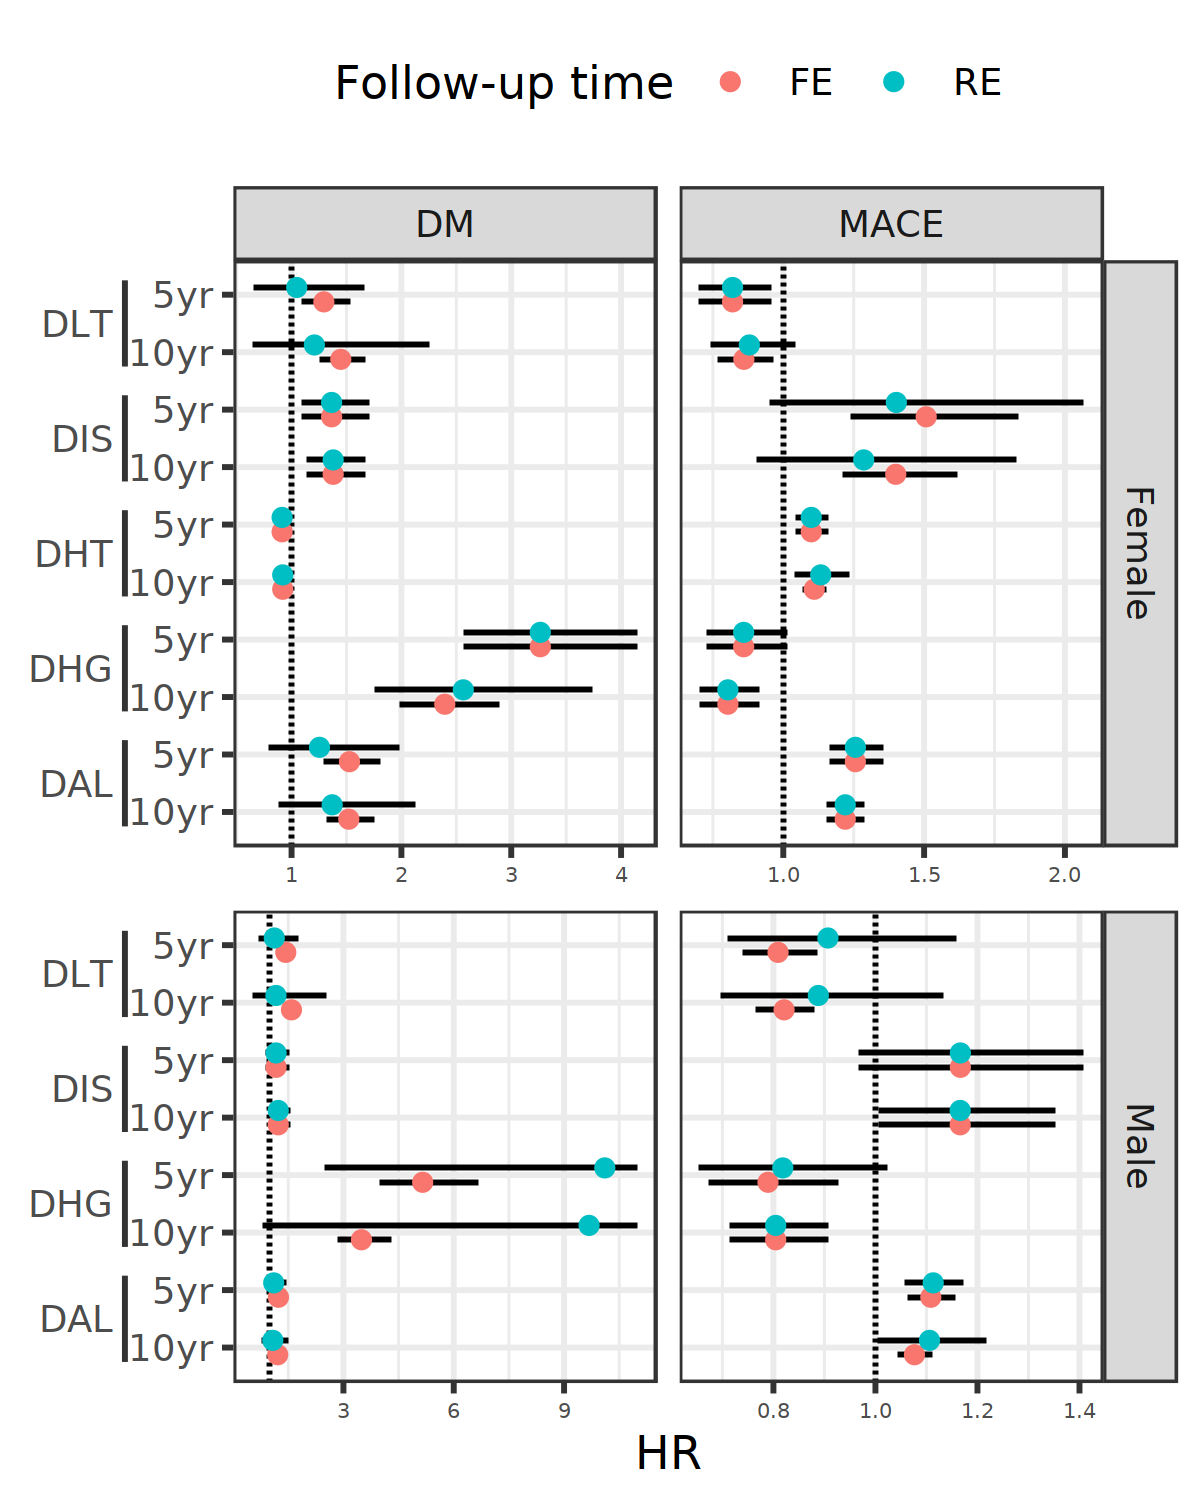

In [96]:
options(repr.plot.width = 4, repr.plot.height = 5)
poolshift50est %>%
    mutate(
        hr = exp(estimate),
        lwr = exp(estimate - qnorm(.975)*se),
        upr = exp(estimate + qnorm(.975)*se),
        fut = factor(
            paste0(fut, "yr"), 
            levels = c("10yr", "5yr")
        ),
        cohort = gsub("Pooled_", "", cohort),
        Cluster = gsub("prob", "", Cluster)
    ) %>%
    ggplot(aes(hr, interaction(fut, Cluster))) +
    geom_vline(xintercept = 1, lty = "dashed") +
    geom_linerange(
        aes(xmin = lwr, xmax = pmin(11, upr), group = cohort),
        position = position_dodge(width = .5)
    ) +
    geom_point(
        aes(group = cohort, color = cohort),
        position = position_dodge(width = .5)
    ) +
    scale_y_discrete(guide = ggh4x::guide_axis_nested()) +
    ggh4x::facet_nested(
        sex ~ outcome, scales = "free",
        independent = "x",
        space = "free_y"
    ) +
    labs(x = "HR", y = NULL, color = "Follow-up time") +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5),
        legend.position = "top"
    )

In [97]:
allshift50est <- poolshift50est %>%
    bind_rows(shift50est) %>%
    mutate(
        cohort = factor(
            case_match(
                cohort,
                "ukb" ~ "UKB",
                "maastricht" ~ "MAS",
                "rotterdam" ~ "RTD",
                "ghs" ~ "GHS",
                .default = cohort
            ),
            levels = c("UKB", "MAS", "RTD", "GHS", "Pooled_FE", "Pooled_RE")
        ),
        pval = 2*pnorm(-abs(estimate/se)),
        hr = exp(estimate),
        lwr = exp(estimate - qnorm(.975)*se),
        upr = exp(estimate + qnorm(.975)*se)
    ) %>%
    transmute(
        sex, outcome, Cluster, fut, cohort,
        across(everything())
    ) %>%
    arrange(sex, outcome, Cluster, fut, cohort)
head(allshift50est)

sex,outcome,Cluster,fut,cohort,estimate,se,pval,hr,lwr,upr
<chr>,<chr>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,DM,DAL,5,UKB,0.5707823,0.10134850,1.782583e-08,1.7696510,1.4508403,2.158518
Female,DM,DAL,5,RTD,0.1953094,0.19035534,3.048796e-01,1.2156871,0.8371264,1.765438
Female,DM,DAL,5,GHS,-0.2698058,0.29338405,3.577643e-01,0.7635277,0.4296313,1.356919
Female,DM,DAL,5,Pooled_FE,0.4234024,0.08556954,7.496056e-07,1.5271487,1.2913513,1.806002
Female,DM,DAL,5,Pooled_RE,0.2264435,0.23371271,3.325968e-01,1.2541317,0.7932435,1.982804
Female,DM,DAL,10,UKB,0.5231434,0.08181730,1.615548e-10,1.6873233,1.4373260,1.980803


In [99]:
write_tsv(allshift50est, "../data/allshift50est.tsv")

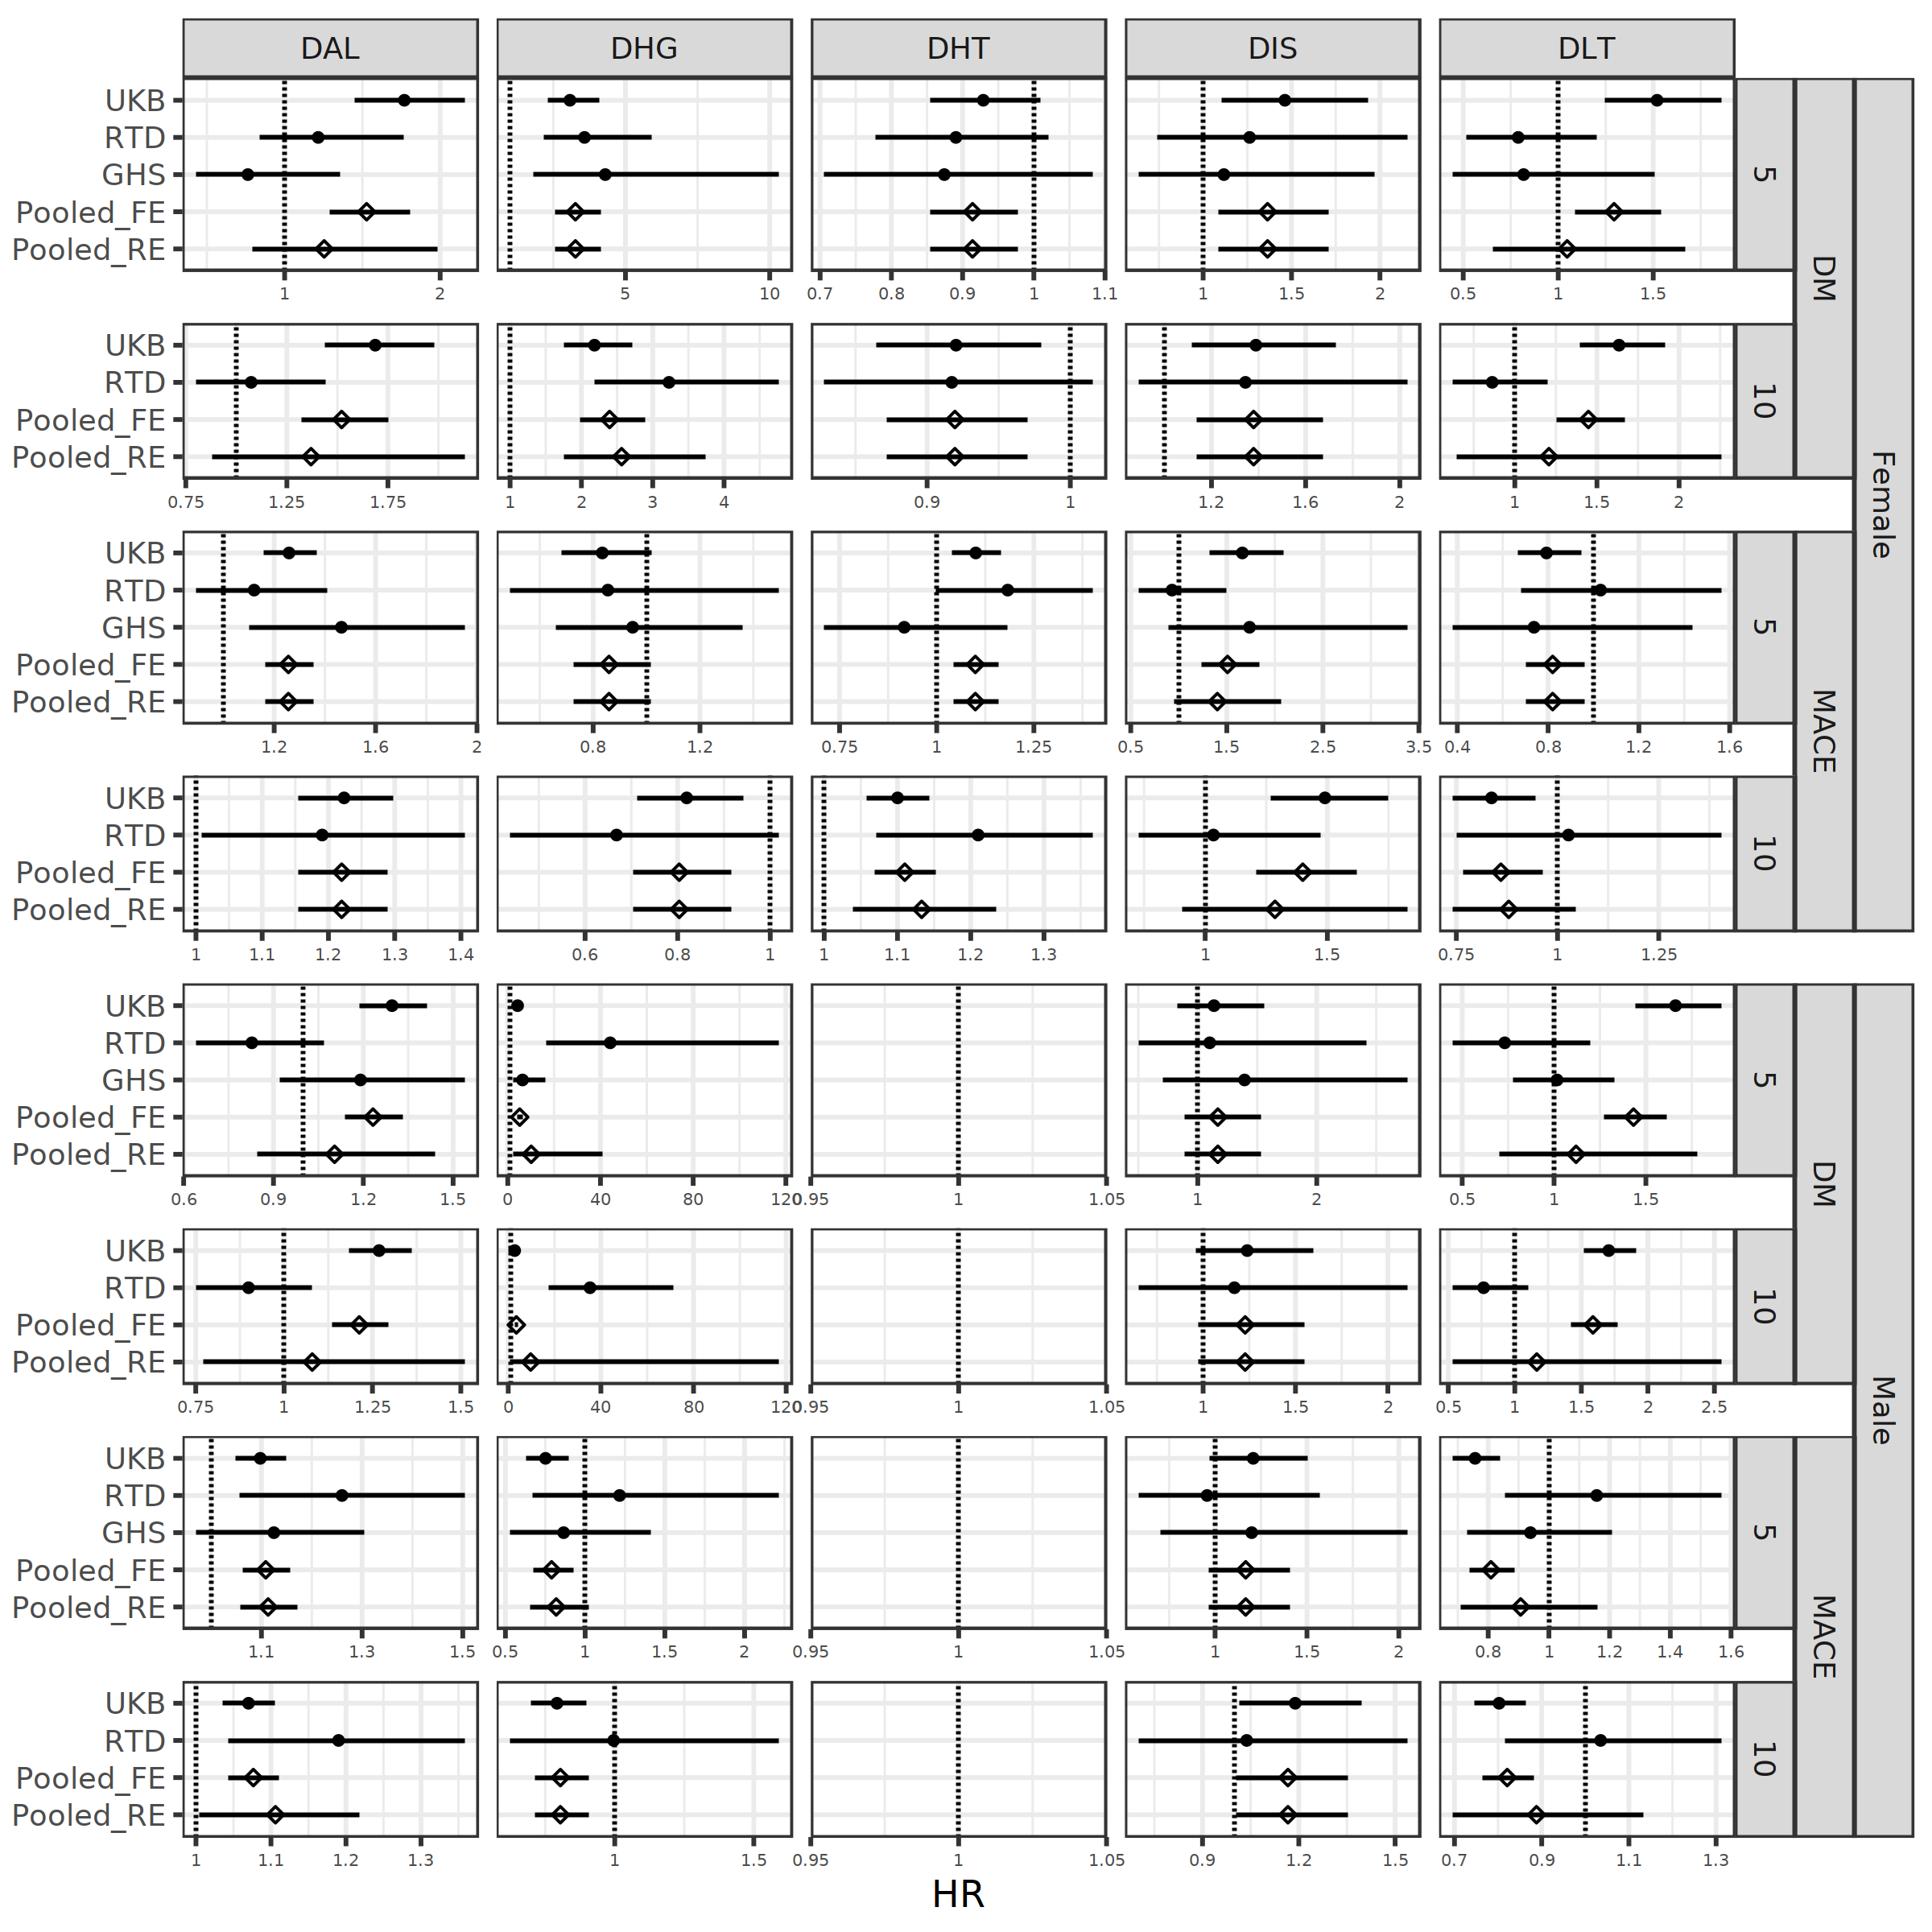

In [98]:
options(repr.plot.width = 8, repr.plot.height = 8)
allshift50est %>%
    drop_na %>%
    mutate(Cluster = gsub("prob", "", Cluster)) %>%
    ggplot(aes(hr, reorder(cohort, desc(cohort)))) +
    geom_vline(xintercept = 1, lty = "dashed") +
    geom_linerange(aes(xmin = lwr, xmax = upr)) +
    geom_point(aes(shape = grepl("Pooled", cohort)), show.legend = FALSE) +
    scale_shape_manual(values = c(20, 23)) +
    ggh4x::facet_nested(
        sex+outcome+fut~Cluster, scales = "free", independent = "x",
        space = "free_y"
    ) +
    scale_x_continuous(n.breaks = 4, labels = \(x)round(x, 2)) +
    labs(x = "HR", y = NULL) +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5)
    )

### Mapping the 50% shift (visible in the map)

In [100]:
umapmoddf <- tibble(sex = c("Female", "Male")) %>%
    mutate(
        umapmod = map(
            sex, 
            ~uwot::load_uwot(
                paste0("../data/ukb/umapmod_", .x)
            )
        )
    )
print(umapmoddf)

# A tibble: 2 x 2
  sex    umapmod          
  <chr>  <list>           
1 Female <named list [26]>
2 Male   <named list [26]>


In [101]:
shift50pcmap <- shift50pc %>%
    inner_join(umapmoddf) %>%
    transmute(
        sex,
        CoordUMAP = map2(
            ResD, umapmod,
            function(RESD, UMAPMOD){
                D <- RESD %>%
                    mutate(
                        RGD = map(RGD, ~data.frame(t(.x)))
                    ) %>%
                    unnest(RGD)
                data.frame(
                    Cluster = D$Cluster,
                    uwot::umap_transform(select(D, -Cluster), UMAPMOD)
                )
            }
        )
    ) %>%
    unnest(CoordUMAP)
shift50pcmap

Joining with `by = join_by(sex)`


sex,Cluster,X1,X2
<chr>,<chr>,<dbl>,<dbl>
Female,BC,0.04982406,0.15587135
Female,DAL,0.58551514,-0.32987285
Female,DHG,-1.21476626,-0.96306831
Female,DHT,0.17658664,0.54027486
Female,DIS,-0.04486629,-1.39274764
Female,DLT,1.33310091,0.25067762
Male,BC,-0.09807766,-0.07278727
Male,DAL,-0.34979698,0.44254589
Male,DHG,1.49524856,0.64674705


In [102]:
shift50pcmapdir <- shift50pcmap %>%
    pivot_wider(names_from = Cluster, values_from = c(X1, X2)) %>%
    pivot_longer(-c(sex, X1_BC, X2_BC), values_drop_na = TRUE,
                 names_to = c(".value", "Cluster"), names_sep = "_")
shift50pcmapdir

sex,X1_BC,X2_BC,Cluster,X1,X2
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Female,0.04982406,0.15587135,DAL,0.58551514,-0.3298728
Female,0.04982406,0.15587135,DHG,-1.21476626,-0.9630683
Female,0.04982406,0.15587135,DHT,0.17658664,0.5402749
Female,0.04982406,0.15587135,DIS,-0.04486629,-1.3927476
Female,0.04982406,0.15587135,DLT,1.33310091,0.2506776
Male,-0.09807766,-0.07278727,DAL,-0.34979698,0.4425459
Male,-0.09807766,-0.07278727,DHG,1.49524856,0.6467471
Male,-0.09807766,-0.07278727,DIS,0.39977720,1.3407015
Male,-0.09807766,-0.07278727,DLT,-0.99407262,0.2068984


In [103]:
embeddf <- umapmoddf %>%
    mutate(umapmod = map(umapmod, ~data.frame(.x$embedding))) %>%
    unnest(umapmod)
head(embeddf)

sex,X1,X2
<chr>,<dbl>,<dbl>
Female,-0.1854294,0.8024553
Female,0.3772524,0.4998869
Female,-0.3064628,0.2833304
Female,0.7155038,0.4197675
Female,-0.2389937,0.7671190
Female,-0.6407928,0.4642103


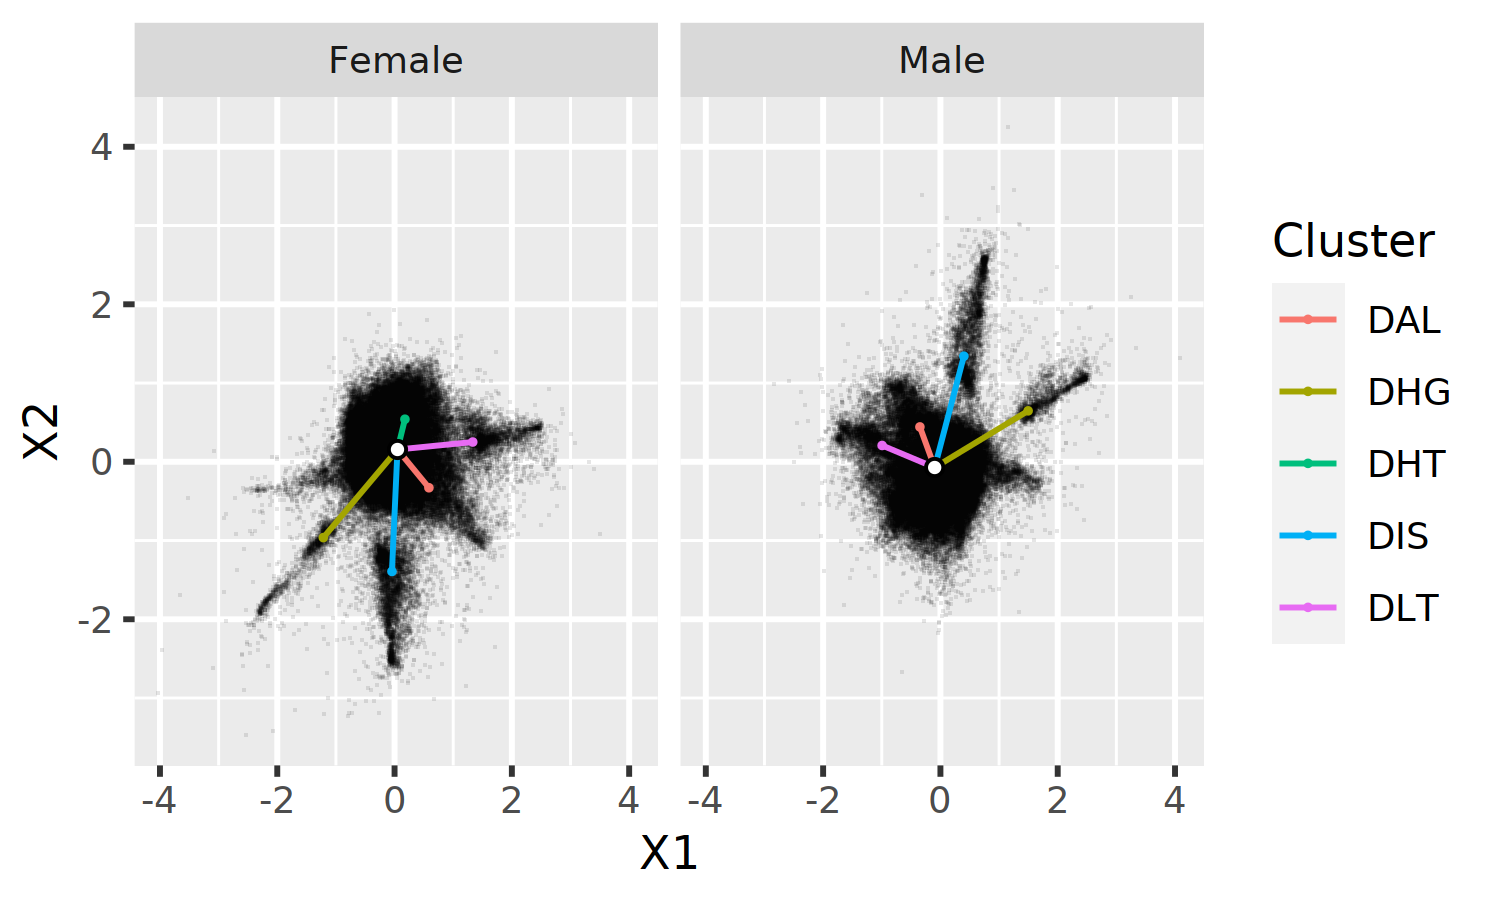

In [104]:
options(repr.plot.width = 5, repr.plot.height = 3)
embeddf %>%
    ggplot(aes(X1, X2)) +
    geom_point(shape = ".", alpha = .1) +
    facet_wrap(~sex) +
    geom_segment(data = shift50pcmapdir, aes(xend = X1_BC, yend = X2_BC, color = Cluster)) +
    geom_point(data = shift50pcmapdir, aes(color = Cluster), size = .2) +
    geom_point(data = unique(transmute(shift50pcmapdir, sex, X1 = X1_BC, X2 = X2_BC)),
               shape = 21, fill = "white", color = "black")

## Full shift from concordant to discordant clusters

In [78]:
fullshiftdat <- validclusmod %>%
    transmute(
        sex,
        NewD = pmap(
            list(residmod, clusmod, sex),
            function(RESIDMOD, CLUSMOD, SEX){
                X <- transmute(
                    RESIDMOD,
                    Intercept,
                    bmi = bmi*30, 
                    age = age*60
                )
                X <- rowSums(X)
                bmnms <- RESIDMOD$Biomarker
                names(X) <- bmnms
                sds <- RESIDMOD$SDRes
                mus <- CLUSMOD$validclus_centers
                mus <- map(mus, function(mu){ mu[bmnms] })
                clusd <- t((do.call(cbind, mus) * sds) + X)
                clusd <- cbind(
                    clusd, 
                    tchol = clusd[,"hdl"] + clusd[,"ldl"] + (clusd[,"tg"]/2.2),
                    age_sbp = 60*clusd[,"sbp"],
                    age_hdl = 60*clusd[,"hdl"],
                    age_fg = 60*clusd[,"fg"],
                    lnegfr = log(egfrcalc(clusd[,"scr"], SEX, 60))
                )
                clusd <- cbind(
                    clusd,
                    age_tchol = 60*clusd[,"tchol"],
                    lnegfrsq = clusd[,"lnegfr"]^2,
                    age_lnegfr = 60*clusd[,"lnegfr"]
                )
                RESIDDF <- do.call(rbind, mus)
                covmats <- CLUSMOD$validclus_covmats
                covmats <- map(covmats, function(covmat){ covmat[bmnms, bmnms] })
                wts <- CLUSMOD$validclus_weights
                pdfs <- mapply(
                    function(mu, covmat){ mvtnorm::dmvnorm(RESIDDF, mu, covmat) },
                    mus, covmats
                )
                L <- pdfs %*% diag(wts)
                probd <- L / rowSums(L)
                clusnm <- CLUSMOD$validclus_name
                colnames(probd) <- rownames(probd) <- paste0("alrprob", clusnm)
                cclus <- colnames(probd) == "alrprobBC"
                alrprobd <- log(t(t(probd[,!cclus]) / probd[,cclus]))
                cbind(clusd, alrprobd)
            }
        )
    )
print(fullshiftdat)

# A tibble: 2 x 2
  sex    NewD          
  <chr>  <list>        
1 Female <dbl [6 x 23]>
2 Male   <dbl [5 x 22]>


In [81]:
fullshiftdat$NewD %>%
    walk(print)

                 whr      sbp      dbp      alt      scr       crp      hdl
alrprobBC  0.8381200 141.7625 83.32733 21.70045 65.29099  3.235890 1.549490
alrprobDHT 0.8111077 172.4024 98.73536 19.20900 64.58671  2.522740 1.580490
alrprobDAL 0.8808578 142.4023 84.07776 23.93656 63.56078  2.922231 1.217338
alrprobDLT 0.8574432 141.6335 84.39081 58.03867 63.55074  3.092555 1.491959
alrprobDIS 0.8391696 141.0059 82.94917 19.23208 64.03624 15.245242 1.487685
alrprobDHG 0.8556050 139.1751 79.92859 22.14040 62.92861  2.732552 1.434742
                 tg      ldl       fg    tchol   age_sbp  age_hdl   age_fg
alrprobBC  1.701850 3.744850 5.048040 6.067908  8505.750 92.96940 302.8824
alrprobDHT 1.447519 3.610539 5.039050 5.848991 10344.147 94.82938 302.3430
alrprobDAL 4.141853 4.323454 4.992069 7.423453  8544.138 73.04031 299.5241
alrprobDLT 1.749642 3.777688 5.007802 6.064939  8498.008 89.51754 300.4681
alrprobDIS 1.632855 3.570089 4.997934 5.799981  8460.353 89.26113 299.8760
alrprobDHG 1.78739

In [84]:
fullshiftest <- survcoefd %>%
    inner_join(fullshiftdat, by = "sex") %>%
    filter(model == "clus") %>%
    transmute(
        cohort,
        sex,
        outcome,
        fut,
        estdat = pmap(
            list(NewD, estimates, varcovmat),
            function(CLUSD, BETAS, COVM){
                cclus <- rownames(CLUSD) == "alrprobBC"
                D <- t(t(CLUSD[!cclus,]) - CLUSD[cclus,])
                nm <- intersect(colnames(D), names(BETAS))
                covm <- COVM[nm,nm]
                data.frame(
                    Cluster = gsub("alrprob", "", rownames(D)),
                    estimate = drop(D[,nm] %*% BETAS[nm]),
                    se = apply(
                        D[,nm], 1,
                        \(clus){ 
                            sqrt(drop(clus %*% covm %*% clus))
                        }
                    )
                )
            }
        )
    ) %>%
    unnest(estdat)
head(fullshiftest)

cohort,sex,outcome,fut,Cluster,estimate,se
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
ukb,Female,MACE,5,DHT,0.6530571,0.1486533
ukb,Female,MACE,5,DAL,0.3840800,0.1830504
ukb,Female,MACE,5,DLT,0.6124101,0.2461594
ukb,Female,MACE,5,DIS,0.4629289,0.2815726
ukb,Female,MACE,5,DHG,0.7611195,0.2216744
ukb,Female,MACE,10,DHT,0.5150471,0.1047095


In [85]:
poolfullshiftest <- fullshiftest  %>%
    nest(D = -c(sex, outcome, Cluster, fut)) %>%
    mutate(
        D = map(D, ~meta::metagen(TE = .x$estimate, seTE = .x$se)),
        D = map(
            D, 
            ~tibble(
                cohort = c("Pooled_FE", "Pooled_RE"),
                estimate = c(.x$TE.fixed, .x$TE.random), 
                se = c(.x$seTE.fixed, .x$seTE.random)
            )
        )
    ) %>%
    unnest(D)
head(poolfullshiftest)

sex,outcome,fut,Cluster,cohort,estimate,se
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Female,MACE,5,DHT,Pooled_FE,0.6061147,0.1283357
Female,MACE,5,DHT,Pooled_RE,0.6061147,0.1283357
Female,MACE,5,DAL,Pooled_FE,0.3489450,0.1702904
Female,MACE,5,DAL,Pooled_RE,0.3489450,0.1702904
Female,MACE,5,DLT,Pooled_FE,0.5426889,0.2101242
Female,MACE,5,DLT,Pooled_RE,0.5426889,0.2101242


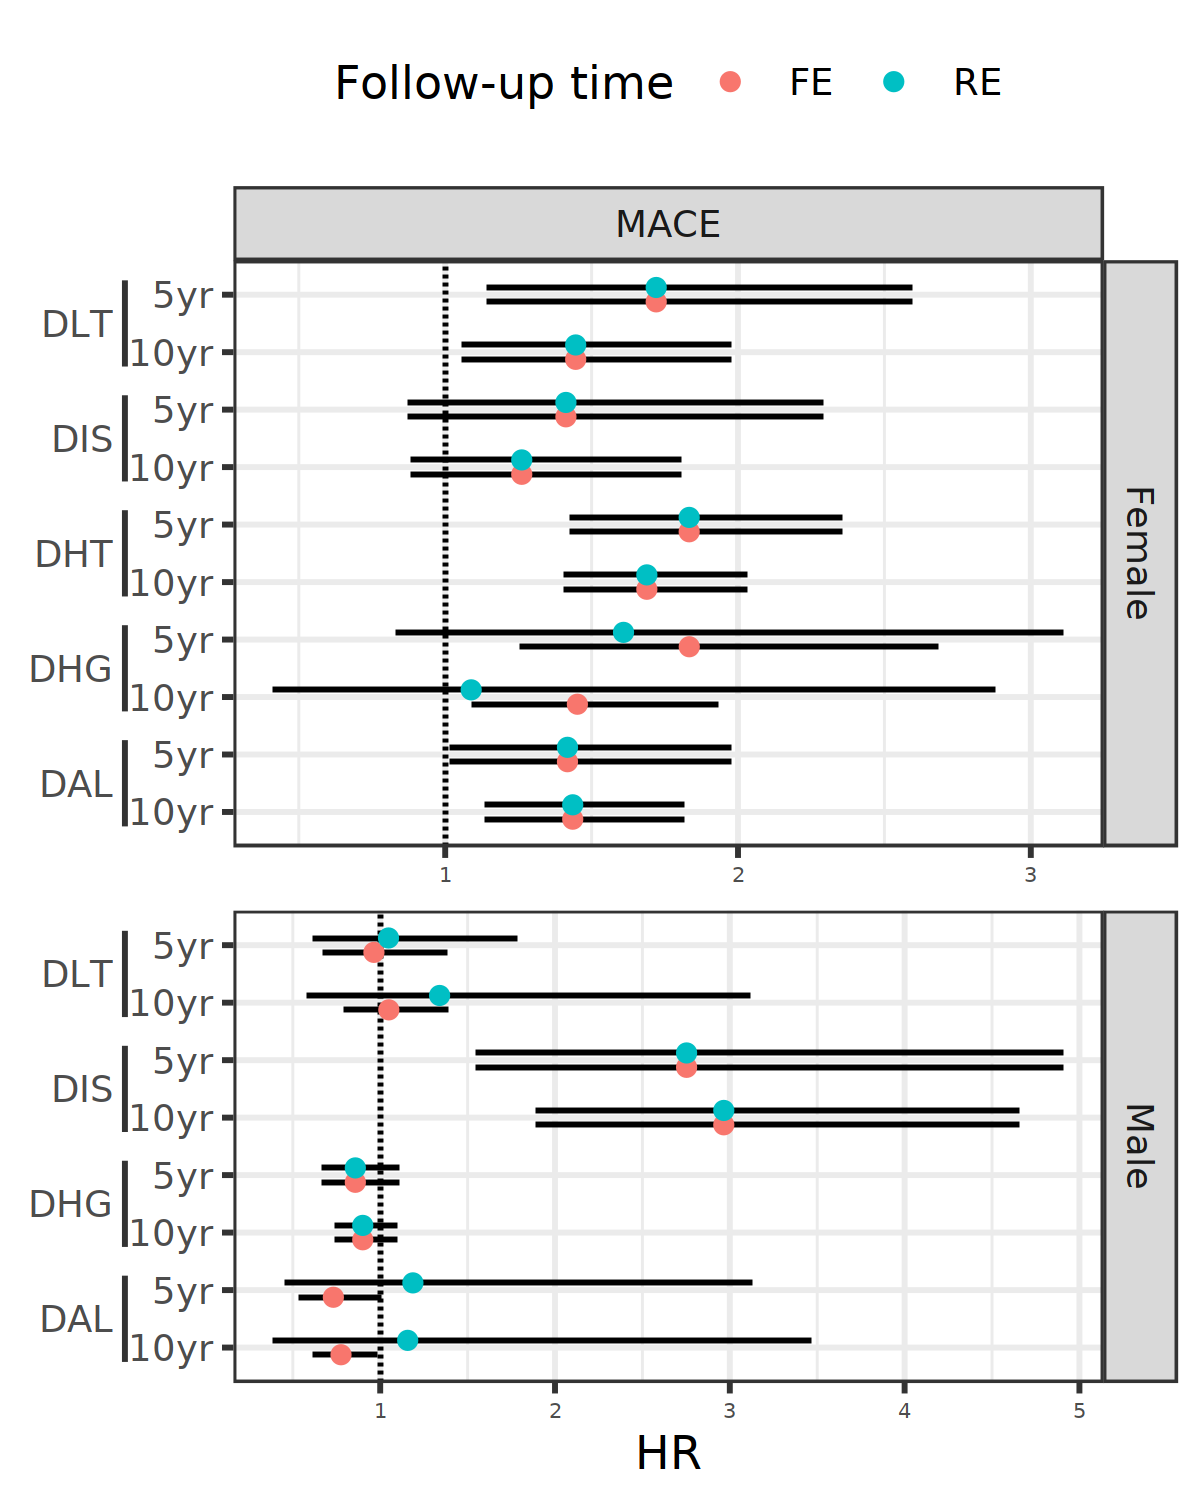

In [86]:
options(repr.plot.width = 4, repr.plot.height = 5)
poolfullshiftest %>%
    filter(outcome == "MACE") %>%
    mutate(
        hr = exp(estimate),
        lwr = exp(estimate - qnorm(.975)*se),
        upr = exp(estimate + qnorm(.975)*se),
        fut = factor(
            paste0(fut, "yr"), 
            levels = c("10yr", "5yr")
        ),
        cohort = gsub("Pooled_", "", cohort),
        Cluster = gsub("prob", "", Cluster)
    ) %>%
    ggplot(aes(hr, interaction(fut, Cluster))) +
    geom_vline(xintercept = 1, lty = "dashed") +
    geom_linerange(
        aes(xmin = lwr, xmax = pmin(11, upr), group = cohort),
        position = position_dodge(width = .5)
    ) +
    geom_point(
        aes(group = cohort, color = cohort),
        position = position_dodge(width = .5)
    ) +
    scale_y_discrete(guide = ggh4x::guide_axis_nested()) +
    ggh4x::facet_nested(
        sex ~ outcome, scales = "free",
        independent = "x",
        space = "free_y"
    ) +
    labs(x = "HR", y = NULL, color = "Follow-up time") +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5),
        legend.position = "top"
    )

In [86]:
allfullshiftest <- poolfullshiftest %>%
    mutate(cohort = "Pooled", .before = 1) %>%
    bind_rows(fullshiftest) %>%
    mutate(
        cohort = factor(
            case_match(
                cohort,
                "ukb" ~ "UKB",
                "maastricht" ~ "MAS",
                "rotterdam" ~ "RTD",
                "ghs" ~ "GHS",
                "Pooled" ~ "Pooled"
            ),
            levels = c("UKB", "MAS", "RTD", "GHS", "Pooled")
        ),
        pval = 2*pnorm(-abs(estimate/se)),
        hr = exp(estimate),
        lwr = exp(estimate - qnorm(.975)*se),
        upr = exp(estimate + qnorm(.975)*se)
    ) %>%
    transmute(
        sex, outcome, Cluster, fut, cohort,
        across(everything())
    ) %>%
    arrange(sex, outcome, Cluster, fut, cohort)
head(allfullshiftest)

sex,outcome,Cluster,fut,cohort,estimate,se,pval,hr,lwr,upr
<chr>,<chr>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,DM,DAL,5,UKB,1.087916,0.2113508,2.640639e-07,2.968082,1.961434,4.491361
Female,DM,DAL,5,RTD,1.952046,0.4384559,8.503773e-06,7.043083,2.982280,16.633250
Female,DM,DAL,5,GHS,1.508913,0.6526688,2.078247e-02,4.521815,1.258230,16.250452
Female,DM,DAL,5,Pooled,1.410628,0.3055502,3.899214e-06,4.098530,2.251870,7.459554
Female,DM,DAL,10,UKB,1.029724,0.1698480,1.339182e-09,2.800294,2.007376,3.906416
Female,DM,DAL,10,RTD,1.939405,0.3355667,7.492605e-09,6.954614,3.602784,13.424804


In [87]:
write_tsv(allfullshiftest, "../data/allfullshiftest.tsv")

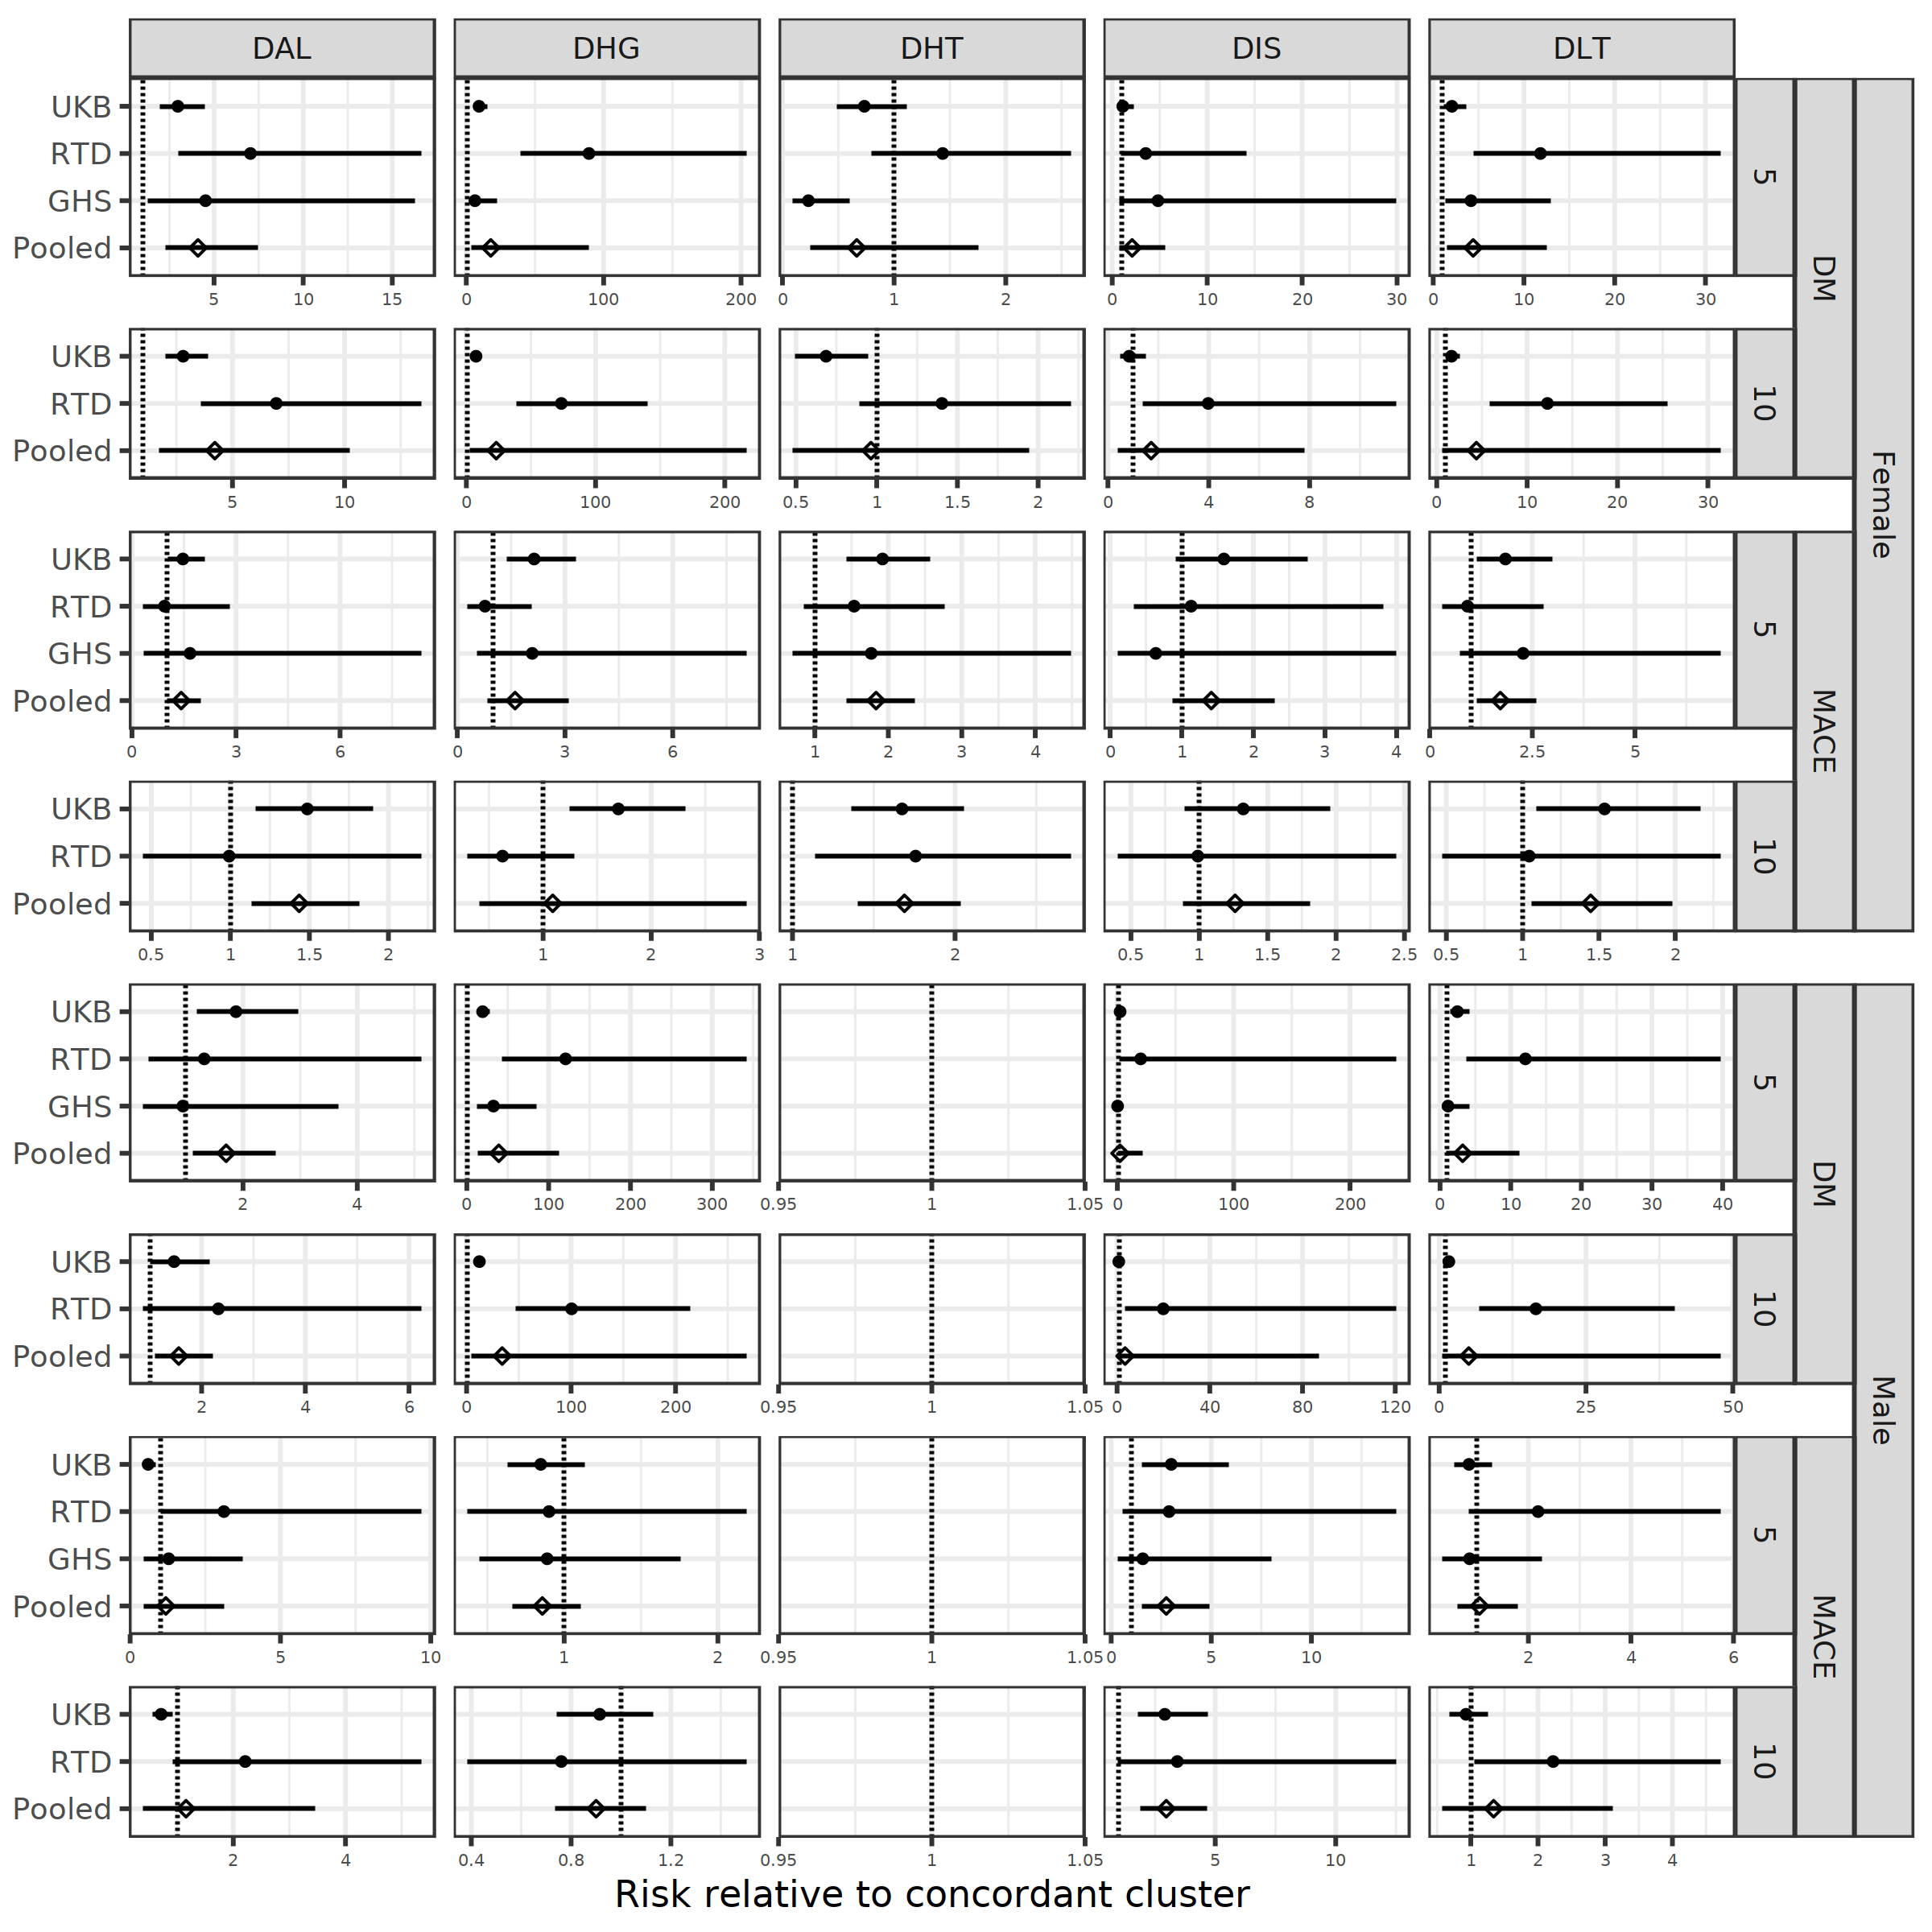

In [88]:
options(repr.plot.width = 8, repr.plot.height = 8)
allfullshiftest %>%
    drop_na %>%
    mutate(Cluster = gsub("prob", "", Cluster)) %>%
    ggplot(aes(hr, reorder(cohort, desc(cohort)))) +
    geom_vline(xintercept = 1, lty = "dashed") +
    geom_linerange(aes(xmin = lwr, xmax = upr)) +
    geom_point(aes(shape = cohort == "Pooled"), show.legend = FALSE) +
    scale_shape_manual(values = c(20, 23)) +
    ggh4x::facet_nested(
        sex+outcome+fut~Cluster, scales = "free", independent = "x",
        space = "free_y"
    ) +
    scale_x_continuous(n.breaks = 4, labels = \(x)round(x, 2)) +
    labs(x = "Risk relative to concordant cluster", y = NULL) +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5)
    )

---

## Adequacy index by cluster

In [537]:
adeqindclus <- result_long %>%
    filter(element_name == "AdeqIndByClus") %>%
    select(-element_name) %>%
    unnest(element_value)
head(adeqindclus)

cohort,sex,outcome,fut,Cluster,AdeqInd
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
ukb,Female,MACE,5,probBC,0.9721397
ukb,Female,MACE,5,probDHT,0.9640652
ukb,Female,MACE,5,probDAL,1.0000000
ukb,Female,MACE,5,probDLT,1.0000000
ukb,Female,MACE,5,probDIS,0.9516598
ukb,Female,MACE,5,probDHG,1.0000000


In [539]:
write_tsv(adeqindclus, "../data/adeqindclus.tsv")

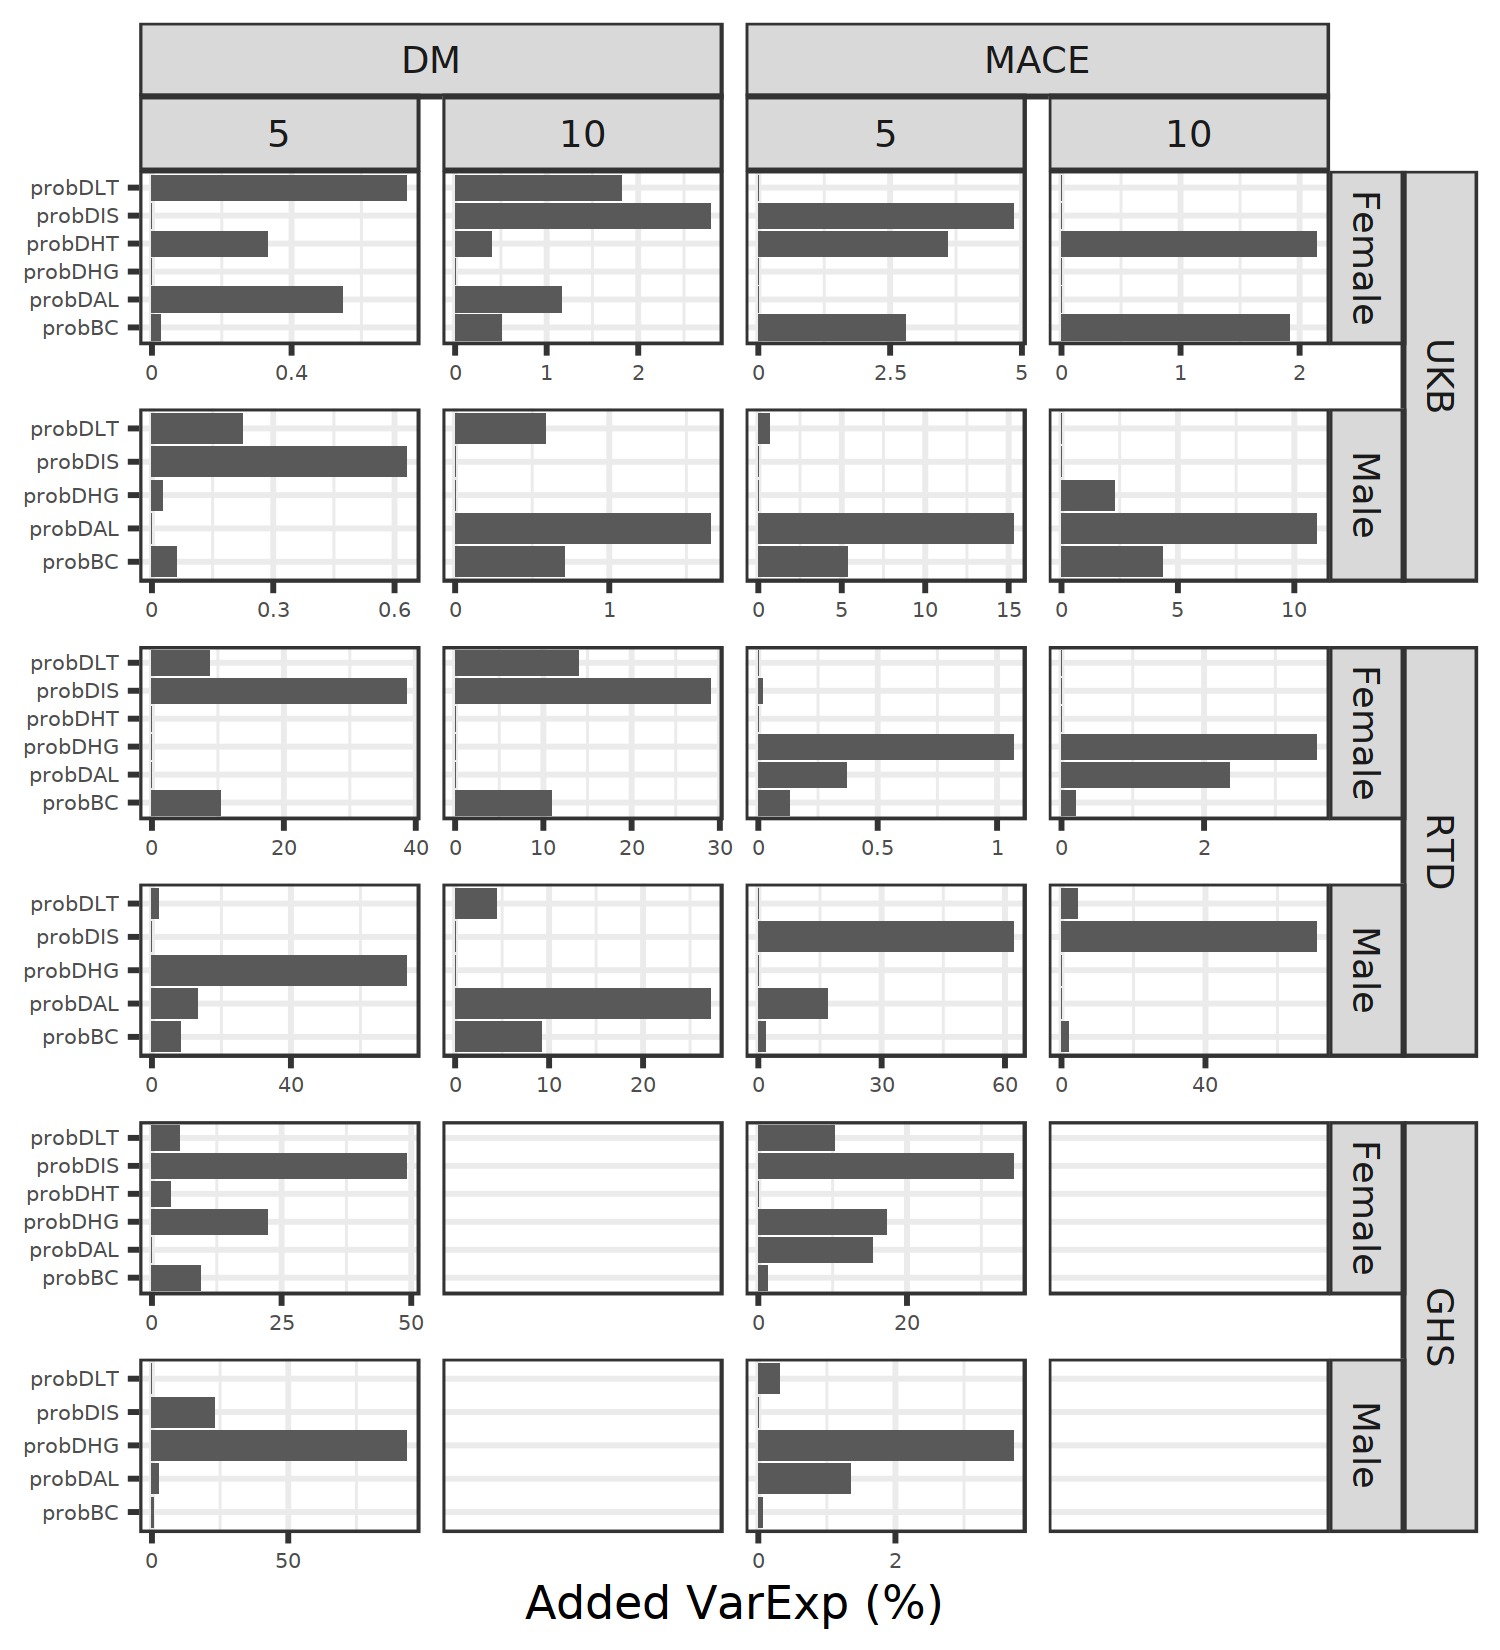

In [640]:
options(repr.plot.width = 5, repr.plot.height = 5.5)
adeqindclus %>%
    mutate(
        cohort = factor(
            case_match(
                cohort,
                "ukb" ~ "UKB",
                "maastricht" ~ "MAS",
                "rotterdam" ~ "RTD",
                "ghs" ~ "GHS",
                "Pooled" ~ "Pooled"
            ),
            levels = c("UKB", "MAS", "RTD", "GHS", "Pooled")
        )
    ) %>%
    ggplot(aes(1 - AdeqInd, Cluster)) +
    geom_col() +
    ggh4x::facet_nested(
        cohort + sex ~ outcome + fut, 
        scales = "free", independent = "x"
    ) +
    scale_x_continuous(n.breaks = 3, labels = \(x)100*x) +
    labs(x = "Added VarExp (%)", y = NULL) +
    theme_bw() +
    theme(
        axis.text = element_text(size = 5)
    )

---

## Decision curves

In [105]:
dcadat <- result_long %>%
    filter(element_name == "DCARes") %>%
    select(-element_name) %>%
    unnest(element_value)
head(dcadat)

cohort,sex,outcome,fut,pred,n,threshold,pos_rate,tp_rate,fp_rate,net_benefit,net_intervention_avoided
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ukb,Female,MACE,5,base,73378,0.00,0.01838426,0.018384257,0.98161574,0.0183842569,NaN
ukb,Female,MACE,5,base,73378,0.01,0.01838426,0.016462700,0.61087792,0.0102922160,0.1805037
ukb,Female,MACE,5,base,73378,0.02,0.01838426,0.012265257,0.32002780,0.0057340770,0.3617569
ukb,Female,MACE,5,base,73378,0.03,0.01838426,0.008258606,0.16134264,0.0032686277,0.4928771
ukb,Female,MACE,5,base,73378,0.04,0.01838426,0.005260432,0.08452125,0.0017387137,0.5821227
ukb,Female,MACE,5,base,73378,0.05,0.01838426,0.003161711,0.04514977,0.0007854068,0.6472376


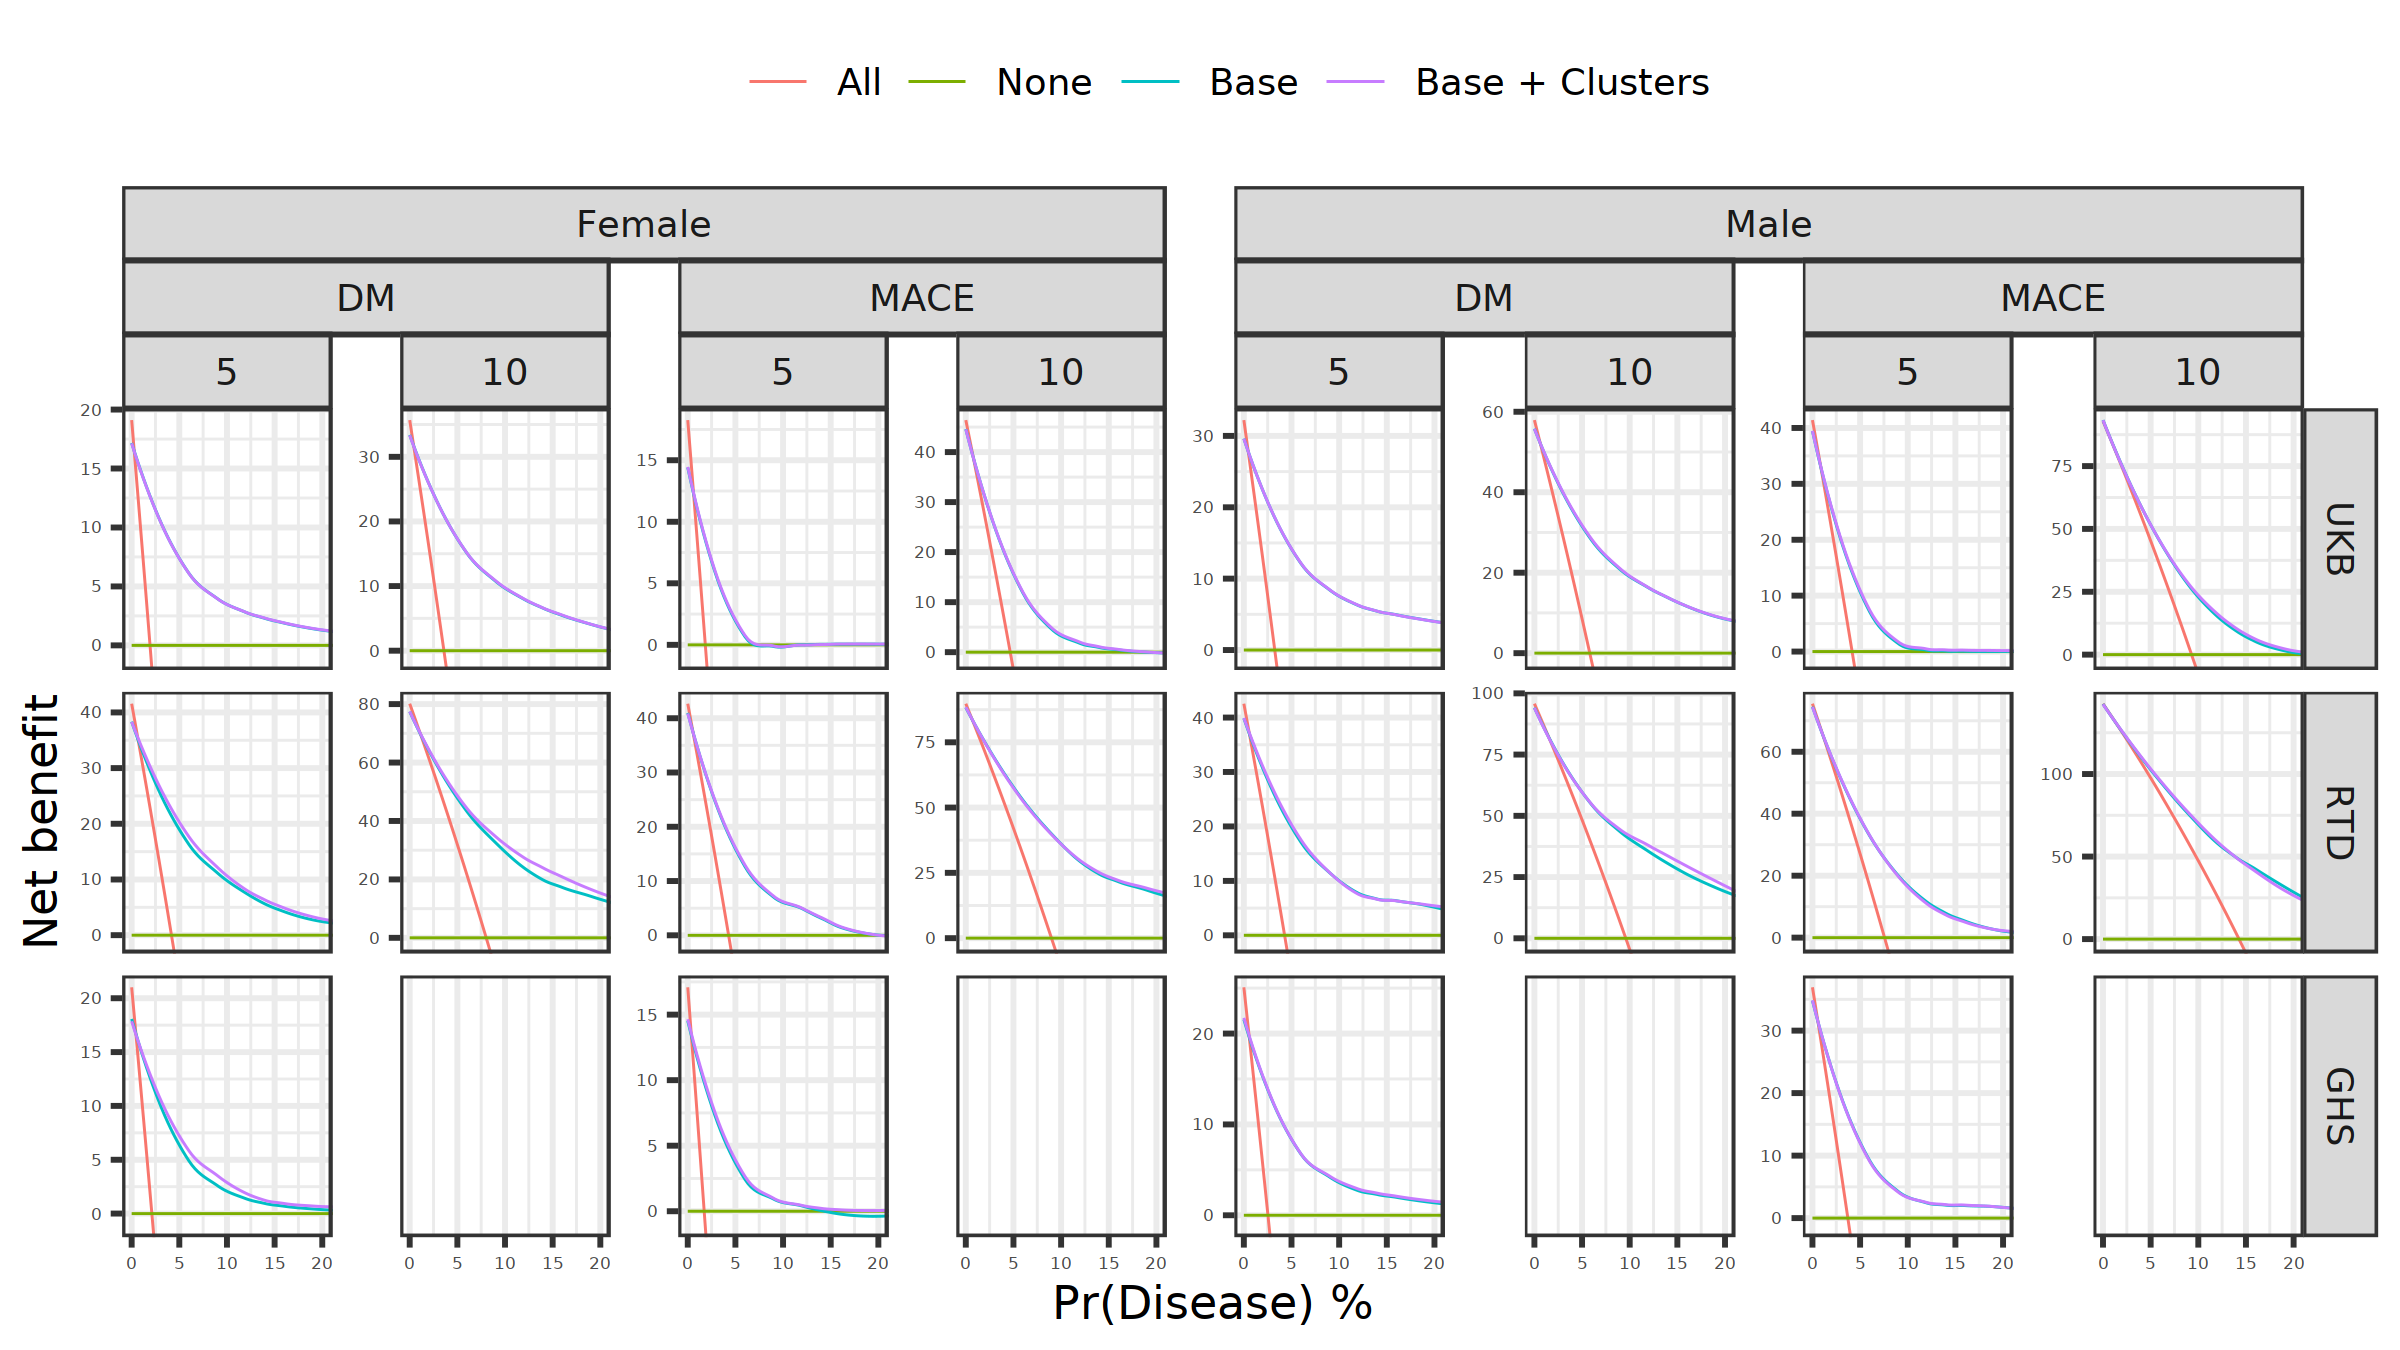

In [120]:
options(repr.plot.width = 8, repr.plot.height = 4.5)
dcadat %>%
    mutate(
        cohort = factor(
            case_match(
                cohort,
                "ukb" ~ "UKB",
                "maastricht" ~ "MAS",
                "rotterdam" ~ "RTD",
                "ghs" ~ "GHS",
                "Pooled" ~ "Pooled"
            ),
            levels = c("UKB", "MAS", "RTD", "GHS", "Pooled")
        ),
        pred = factor(
            case_match(
                pred,
                "all" ~ "All", 
                "none" ~ "None",
                "base" ~ "Base", 
                "clus" ~ "Base + Clusters"
            ),
            levels = c("All", "None", "Base", "Base + Clusters")
        )
    ) %>%
    ggplot(aes(threshold, net_benefit)) +
    geom_smooth(aes(group = pred, color = pred), 
                method = "loess", se = FALSE, formula = y~x,
                linewidth = .25) +
    ggh4x::facet_nested(cohort ~ sex + outcome + fut, scales = "free", independent = "y") +
    coord_cartesian(xlim = c(0, .2), ylim = c(-0.001,NA)) +
    scale_x_continuous(
        breaks = c(0, .05, .1, .15, .2), 
        labels = function(x){ ifelse(x == 0, "0", 100 * x) }
    ) +
    scale_y_continuous(labels = function(x){1000 * x}) +
    labs(x = "Pr(Disease) %", y = "Net benefit", color = "Strategy") +
    theme_bw() +
    theme(
        legend.position = "top", 
        legend.title = element_blank(),
        axis.text = element_text(size = 4)
    )

---